In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [9]:
#find good smoothing techniques that are commonly used in lit


In [22]:
# run only on Umars PC
!jt -t grade3 -fs 95 -altp -tfs 11 -nfs 115 -cellw 88% -T -f firacode -nf firacode


In [23]:
import os, sys
import time

# machine learning
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

# data manipulation and signal processing
import math
import pandas as pd
import numpy as np
import scipy
from scipy import signal
import scipy.stats as ss

# plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import folium


# path = "/content/drive/Shareddrives/covid.eng.pdn.ac.lk/COVID-AI (PG)/spatio_temporal/Covid19_DL_Forecasting_Codes"
# os.chdir(path)
sys.path.insert(0, os.path.join(sys.path[0], '..'))
from utils.plots import bar_metrics, plot_prediction
from utils.functions import split_into_pieces_inorder,split_into_pieces_random,create_dataset_random, distance, convert_lon_lat_to_adjacency_matrix 
from utils.data_loader import load_data, per_million, get_daily
from utils.data_splitter import split_on_region_dimension, split_on_time_dimension
from utils.smoothing_functions import O_LPF,NO_LPF,O_NDA,NO_NDA

# EXTRACTING DATA

In [24]:
daily_data = True
DATASET = "Sri Lanka" # "Texas" "USA" "Global"
# DATASET = "Texas"

## Loading data

Required variables:

*   **region_names** - Names of the unique regions.
*   **confirmed_cases** - 2D array. Each row should corresponds to values in 'region_names'. Each column represents a day. Columns should be in ascending order. (Starting day -> Present)
*   **daily_cases** - confirmed_cases.diff()
*   **population** - Population in 'region'
*   **features** - Features of the regions. Each column is a certain feature.
*   **START_DATE** - Starting date of the data DD/MM/YYYY
*   **n_regions** Number of regions



In [25]:
d = load_data(DATASET,path="../Datasets")
region_names=d["region_names"] 
confirmed_cases=d["confirmed_cases"] 
daily_cases=d["daily_cases"] 
features=d["features"] 
START_DATE=d["START_DATE"] 
n_regions=d["n_regions"] 

population = features["Population"]
for i in range(len(population)):
    print("{:.2f}%".format(confirmed_cases[i,:].max()/population[i]*100), region_names[i])

days = confirmed_cases.shape[1]

print(f"Total population {population.sum()/1e6:.2f}M, regions:{n_regions}, days:{days}")

(25, 126)
['AMPARA', 'ANURADHAPURA', 'BADULLA', 'BATTICOLOA', 'COLOMBO', 'GALLE', 'GAMPAHA', 'HAMBANTOTA', 'JAFFNA', 'KALUTARA', 'KANDY', 'KEGALLE', 'KILINOCHCHI', 'KURUNEGALA', 'MANNAR', 'MONERAGALA', 'MATALE', 'MATARA', 'MULLATIVU', 'NUWARAELIYA', 'POLONNARUWA', 'PUTTALAM', 'RATNAPURA', 'TRINCOMALEE', 'VAVUNIA']
Index(['AMP', 'ANU', 'BAD', 'BAT', 'COL', 'GAL', 'GAM', 'HAM', 'JAF', 'KAL',
       'KAN', 'KEG', 'KIL', 'KUR', 'MAN', 'MON', 'MTL', 'MTR', 'MUL', 'NUW',
       'POL', 'PUT', 'RAT', 'TRI', 'VAN'],
      dtype='object', name='Code')
0.04% AMPARA
0.06% ANURADHAPURA
0.17% BADULLA
0.10% BATTICOLOA
1.21% COLOMBO
0.21% GALLE
0.73% GAMPAHA
0.10% HAMBANTOTA
0.07% JAFFNA
0.51% KALUTARA
0.28% KANDY
0.19% KEGALLE
0.10% KILINOCHCHI
0.15% KURUNEGALA
0.26% MANNAR
0.11% MONERAGALA
0.19% MATALE
0.20% MATARA
0.04% MULLATIVU
0.17% NUWARAELIYA
0.05% POLONNARUWA
0.15% PUTTALAM
0.23% RATNAPURA
0.12% TRINCOMALEE
0.21% VAVUNIA
Total population 21.44M, regions:25, days:126


# Checking the overfiltering and underfiltering problem

In [26]:
def NO_LPF(data, datatype, cutoff, order,plot=True,region_names=None):

    if datatype == 'daily':
        data_sums = np.zeros(data.shape[0],)
        for i in range(data.shape[0]):
            data_sums[i] = np.sum(data[i,:])

    data = np.copy(data.T)
    n_regions = data.shape[1]

    # FILTERING:
    # Filter requirements.
    T = data.shape[0]         
    fs = 1
    nyq = 0.5 * fs  
    # order = 2
    n = int(T * fs)       

    def lowpass_filter(data, cutoff, fs, order):
        normal_cutoff = cutoff / nyq
      # Get the filter coefficients 
        b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
        y = signal.filtfilt(b, a, data)
        return y.astype(np.float32)
    

    columns = 2
    rows = math.ceil(n_regions/columns)
    if plot==True:
        plt.figure(figsize=(6*columns, 4*rows))

    data_filtered = np.zeros_like(data)
    for i in range(n_regions):
        X = data[:,i]
        X_temp = X/np.amax(X)
        Y_temp = lowpass_filter(X_temp, cutoff, fs, order)
        if datatype == 'daily':
              # Y = np.sum(data_sums[i])*Y_temp/np.sum(Y_temp)
            Y = np.copy(Y_temp)
            Y[Y<0]=0
        else:
            for n in range(len(Y)-1):
                if Y[n+1]-Y[n]<0:
                    Y[n+1]=Y[n]
                    Y = np.amax(X)*Y/np.amax(Y)
        data_filtered[:,i] = Y

        if plot==True:
            plt.subplot(rows,columns,i+1)
            plt.title('daily new cases in '+str(region_names[i]))
            plt.plot(X,linewidth=2),plt.plot(Y,linewidth=2,color='r')
            plt.legend(['original','filtered']),plt.xlabel('days')
    if plot==True:     
        plt.show()
    return data_filtered.T

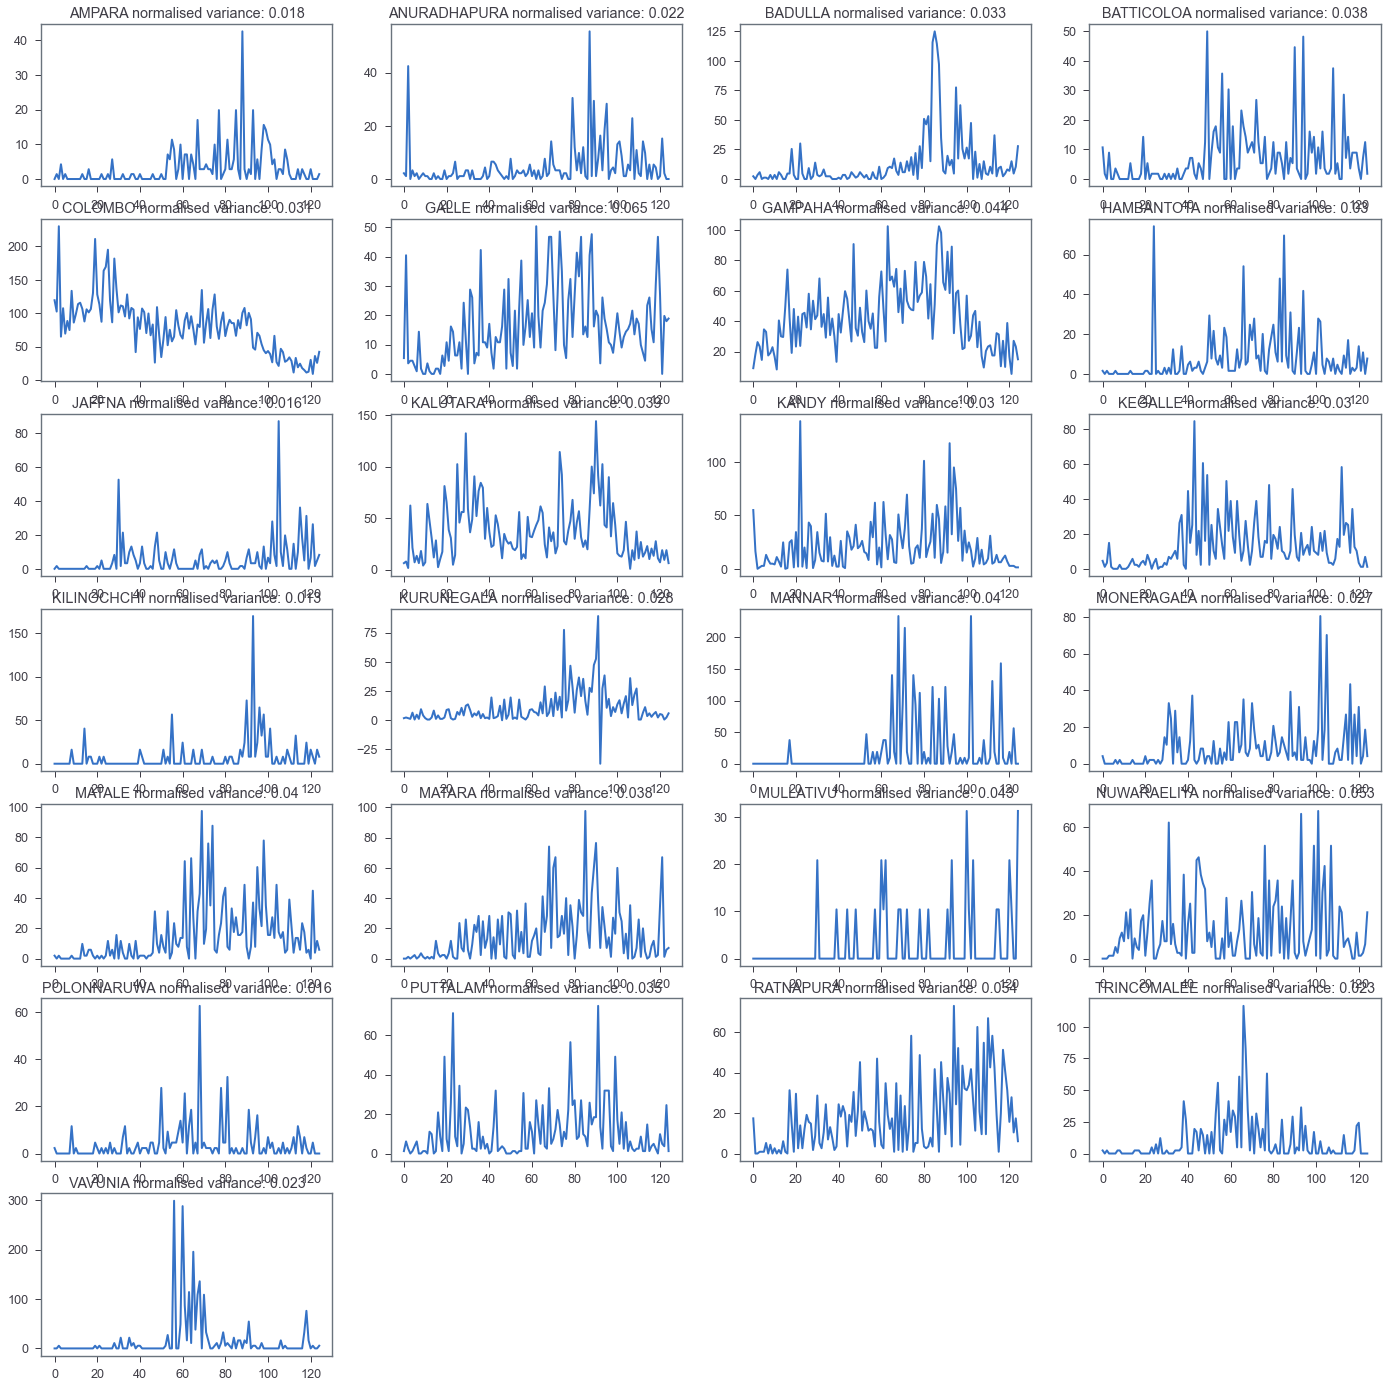

<ipython-input-27-72941e41d3bd>:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(7,4,i+1)


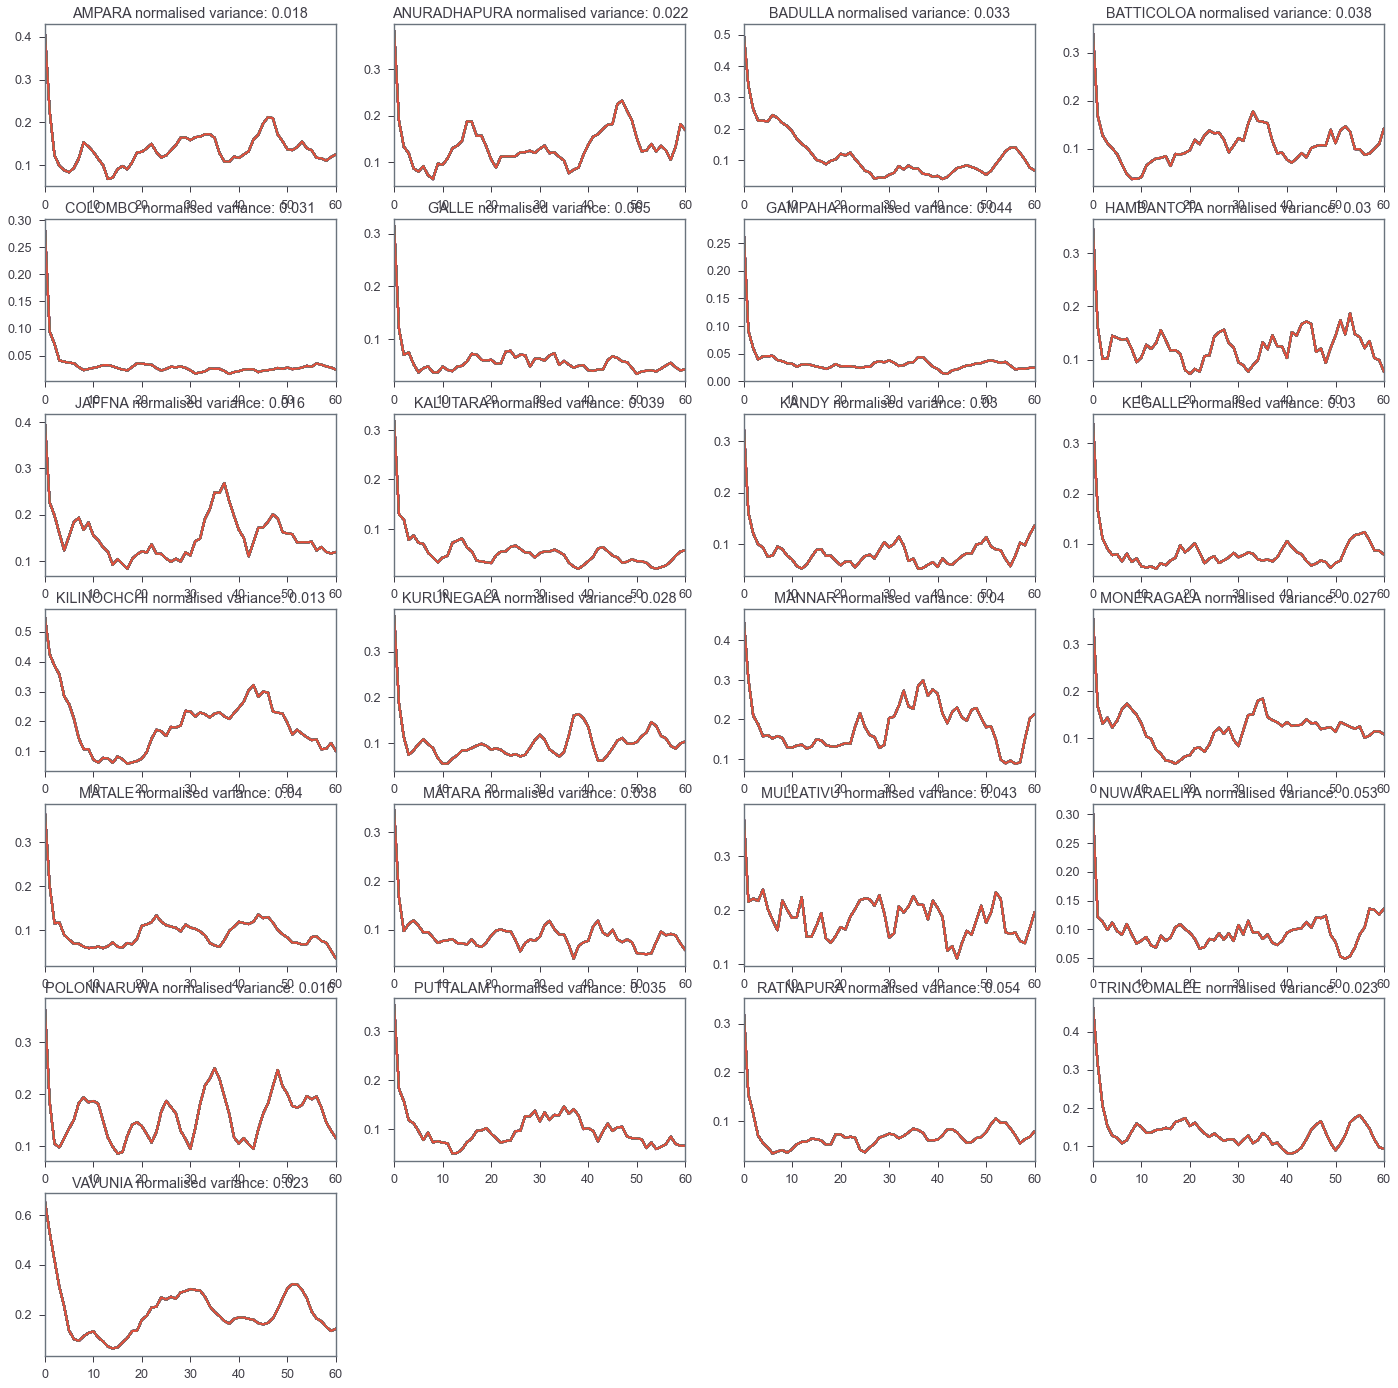

In [27]:
plt.figure(figsize=(6*4,3.5*7))
for i in range(len(region_names)):
    plt.subplot(7,4,i+1)
    plt.plot(1000000*daily_cases[i,:]/population[i], linewidth=2)
    nvar = np.around(np.var(daily_cases[i,:]/np.amax(daily_cases[i,:])),decimals=3)
    plt.title(str(region_names[i])+' normalised variance: '+str(nvar))
plt.show()

plt.figure(figsize=(6*4,3.5*7))
for i in range(len(region_names)):
    _temp = np.abs(scipy.fft.fft(daily_cases[i,:]/np.amax(daily_cases[i,:])))
    _temp = _temp/np.amax(_temp)
    _temp1 = []
    n=5
    for j in range(len(_temp)-n):
        _temp1.append(np.mean(_temp[j:j+n]))
        plt.subplot(7,4,i+1)
        plt.plot(_temp1, linewidth=2)
        nvar = np.around(np.var(daily_cases[i,:]/np.amax(daily_cases[i,:])),decimals=3)
        plt.title(str(region_names[i])+' normalised variance: '+str(nvar))
        plt.xlim([0, 60])
plt.show()

2 4
[0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145, 0.15, 0.155, 0.16, 0.165, 0.17, 0.175, 0.18, 0.185, 0.19, 0.195, 0.2]


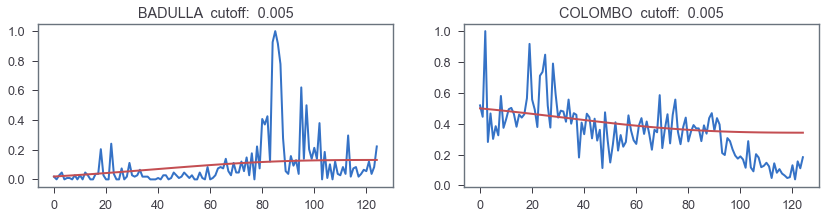

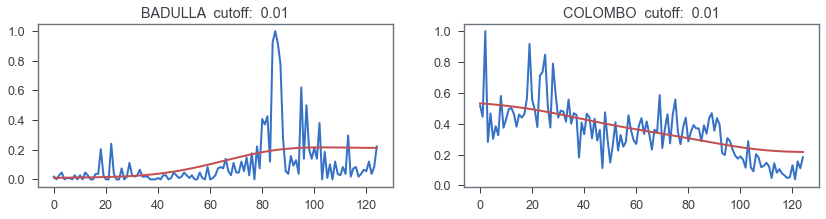

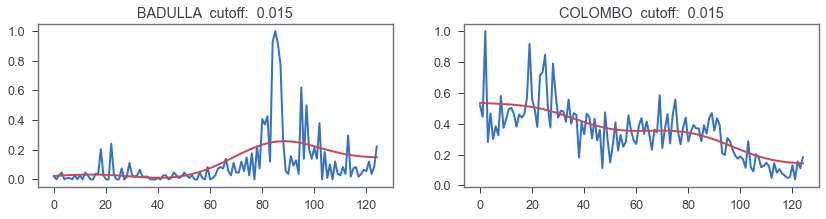

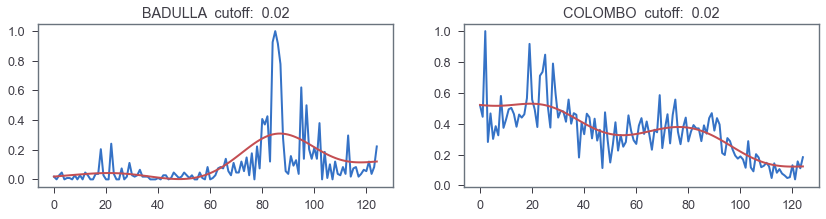

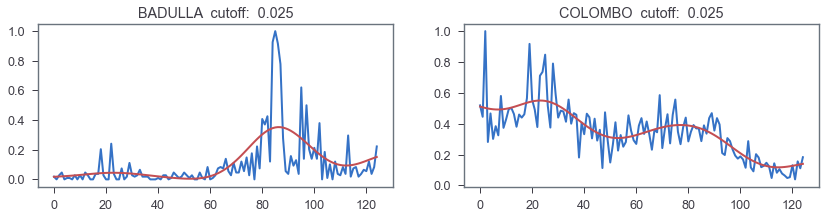

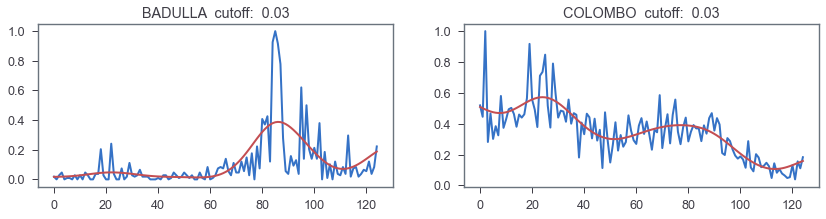

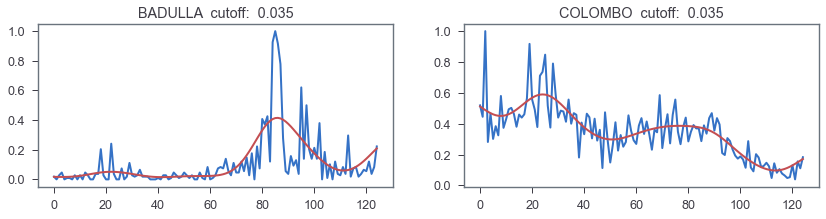

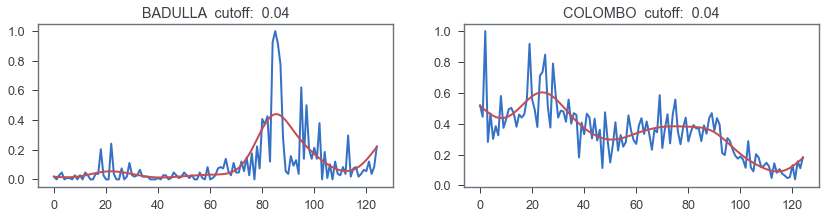

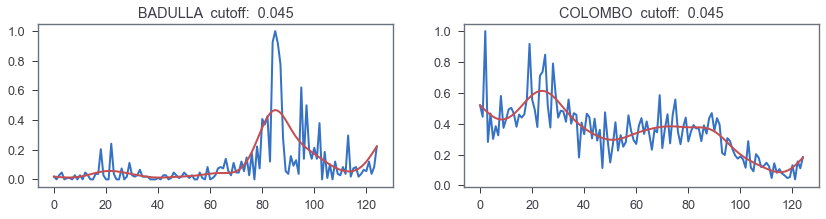

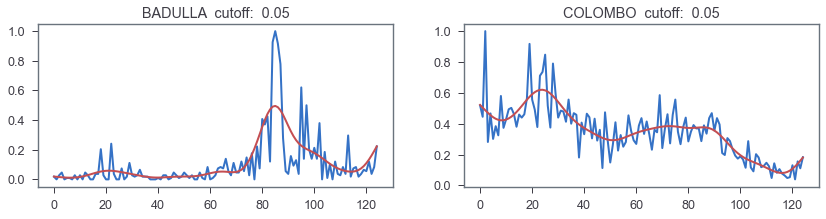

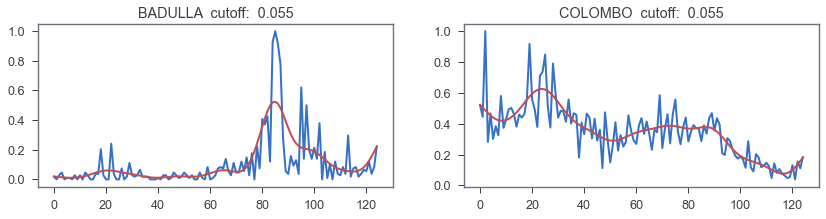

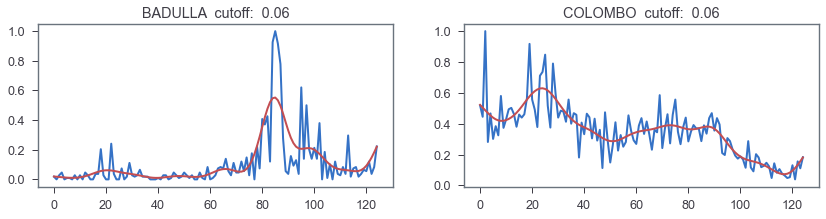

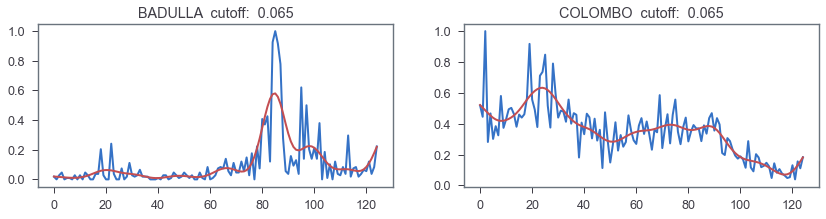

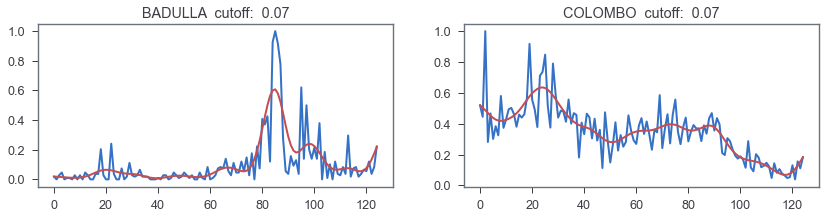

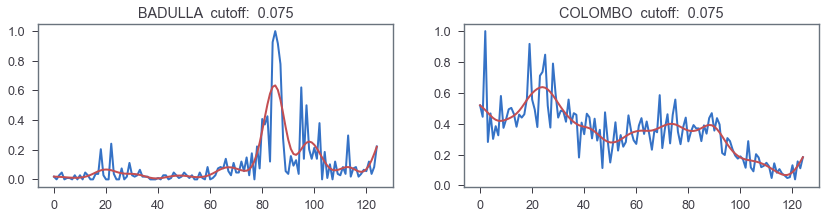

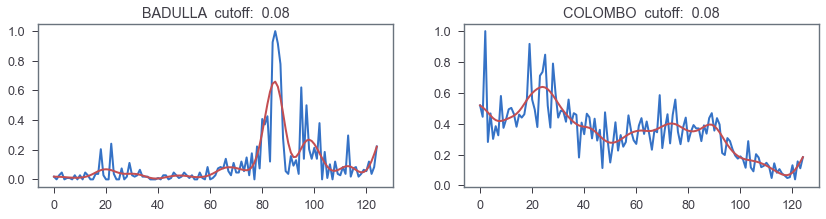

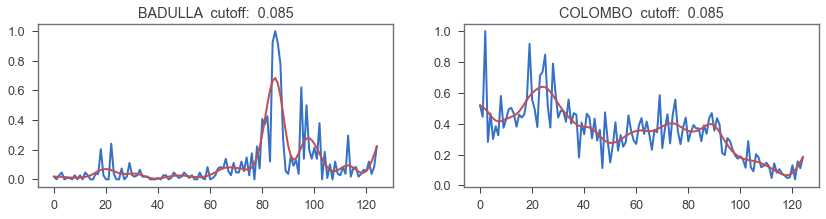

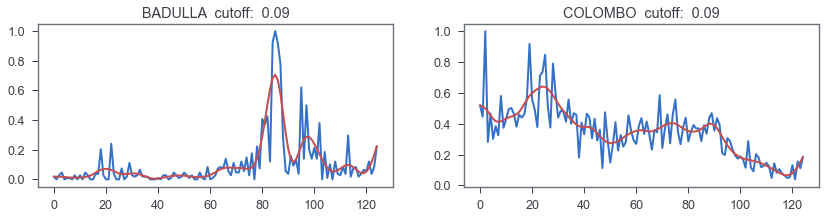

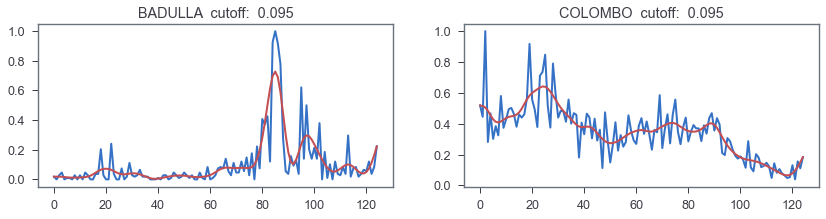

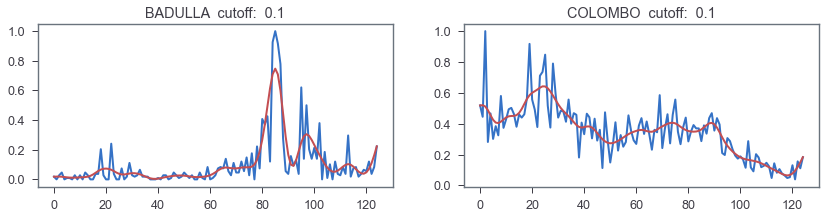

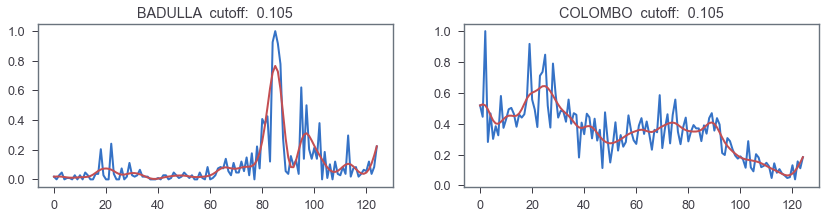

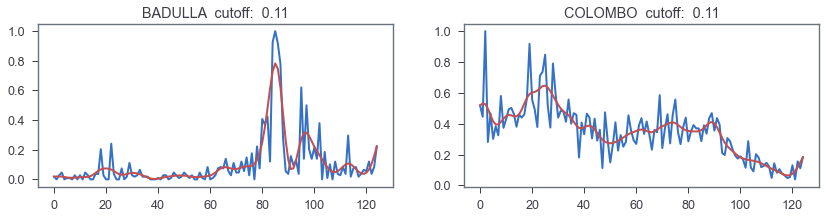

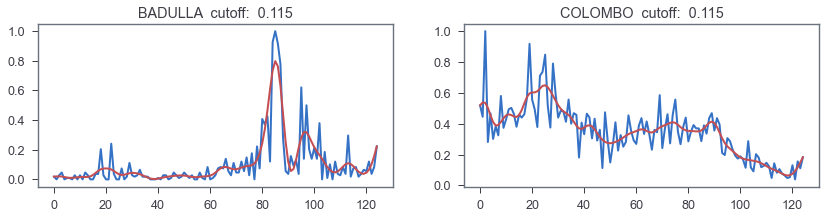

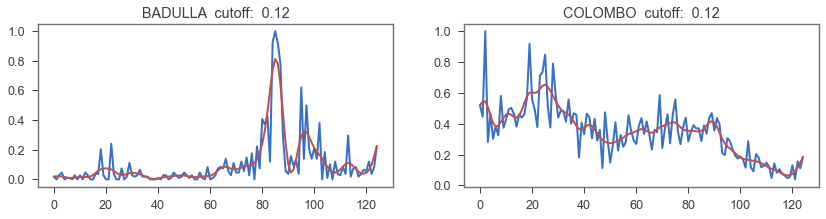

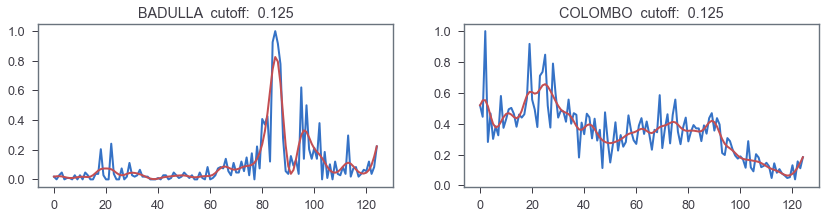

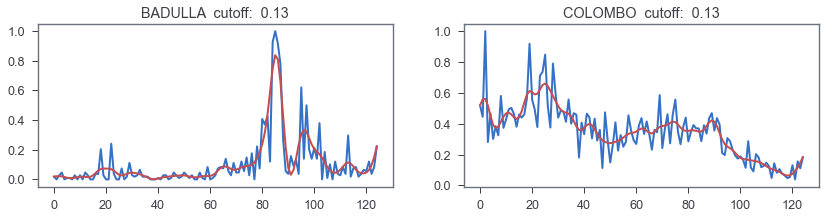

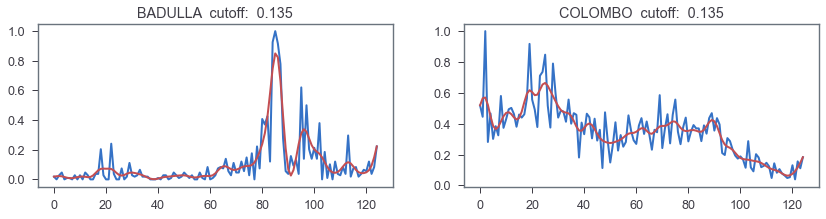

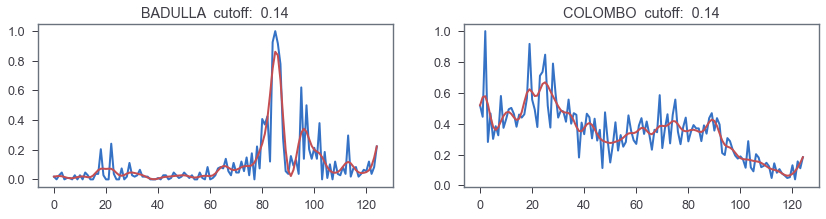

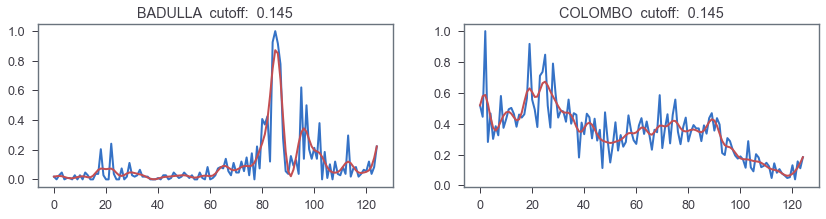

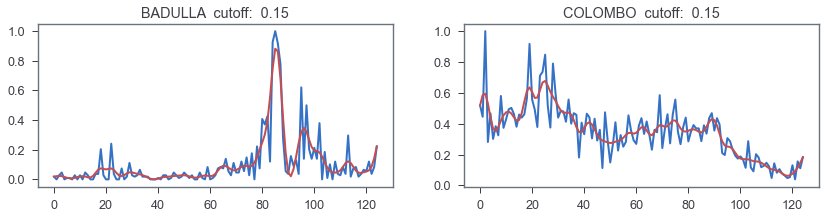

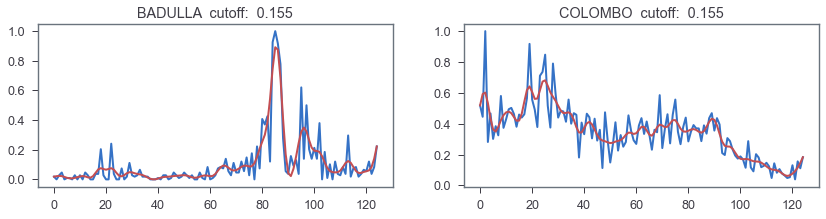

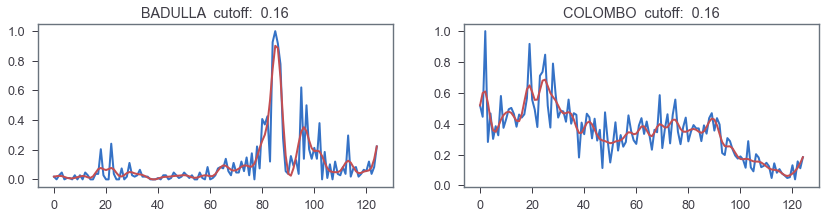

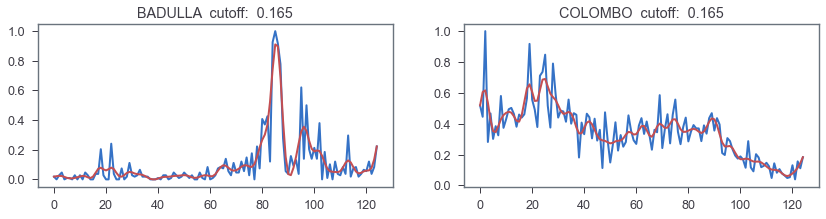

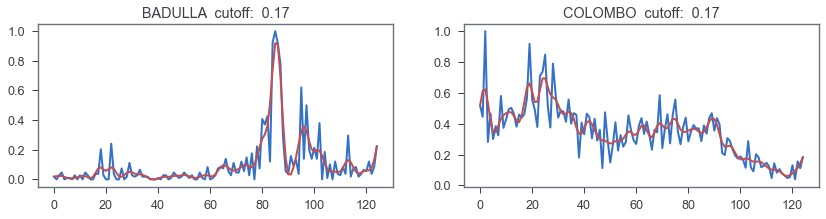

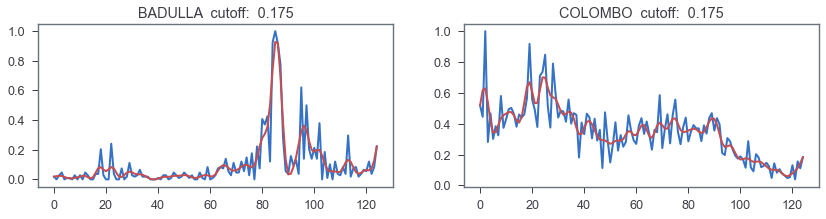

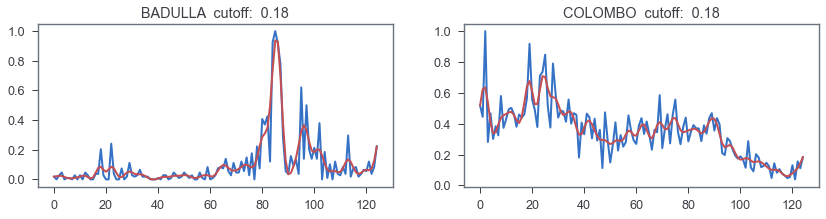

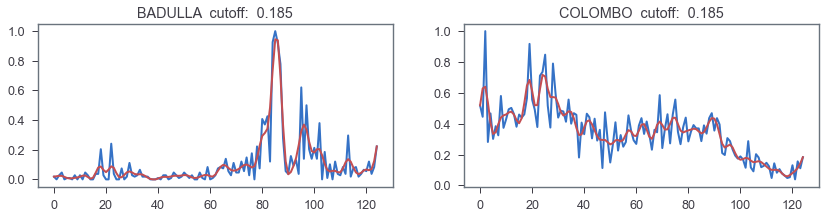

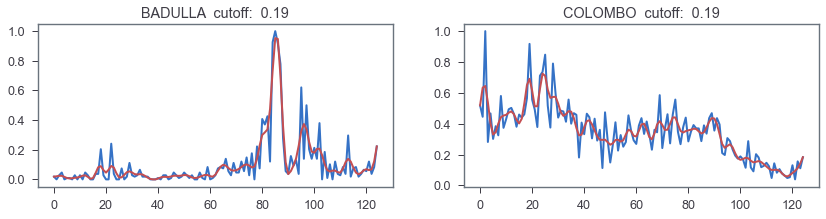

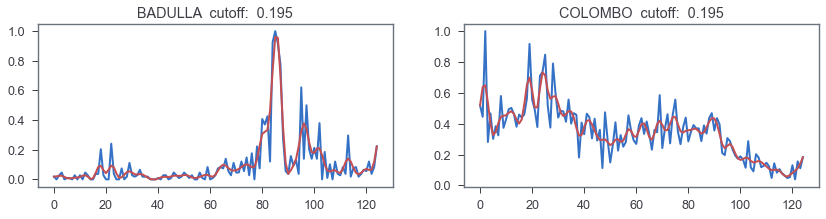

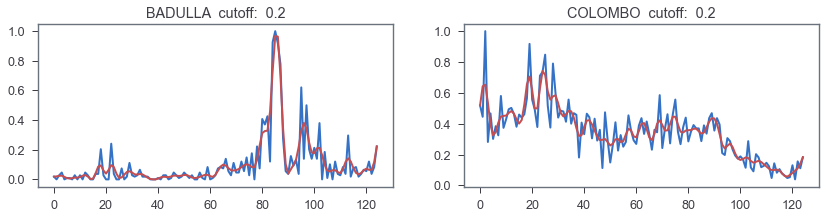

In [30]:
for i in range(len(region_names)):
    if region_names[i] == 'BADULLA':
        idx_kal = i
    elif region_names[i] == 'COLOMBO':
        idx_gam = i

print(idx_kal, idx_gam)

list1 = [idx_kal, idx_gam]

# daily_filtered = NO_LPF(daily_cases, datatype='daily',order=1, cutoff=0.1)
freqs=[]
for i in range(40):
      freqs.append((i+1)/200)

print(freqs)


# compare gampaha and kalutara
# overfiltering 
for j in freqs:
    plt.figure(figsize=(14,3))
    for i in range(len(list1)):
        daily_filtered1 = NO_LPF(daily_cases, datatype='daily',order=3, cutoff=j, plot=False)
        plt.subplot(1,2,i+1)
        plt.plot(daily_cases[list1[i],:]/np.amax(daily_cases[list1[i],:]), linewidth=2)
        plt.plot(daily_filtered1[list1[i],:],linewidth=2,color='r')
        RMSE = np.sqrt(np.mean(np.square(daily_cases[list1[i],:]-daily_filtered1[list1[i],:])))
        plt.title(str(region_names[list1[i]])+ '  cutoff:  '+str(j))
        # plt.subplot(1,2,2)
        # plt.plot(daily_cases[i,:], linewidth=2)
        # RMSE = np.sqrt(np.mean(np.square(daily_cases[i,:]-daily_filtered[i,:])))
        # plt.plot(daily_filtered[i,:],linewidth=2,color='r'),plt.title(str(region_names[i])+ ' optimised '+'RMSE= '+str(np.around(RMSE,2)))
    plt.show()

# # underfiltering 
# for i in list1:
#   daily_filtered1 = NO_LPF(daily_cases, datatype='daily',order=3, cutoff=0.1, plot=False)
#   plt.figure(figsize=(6,3.5))
#   # plt.subplot(1,2,1)
#   plt.plot(daily_cases[i,:], linewidth=2)
#   plt.plot(daily_filtered1[i,:],linewidth=2,color='r')
#   RMSE = np.sqrt(np.mean(np.square(daily_cases[i,:]-daily_filtered1[i,:])))
#   plt.title(str(region_names[i])+ ' unoptimised '+'RMSE= '+str(np.around(RMSE,2)))
#   # plt.subplot(1,2,2)
#   # plt.plot(daily_cases[i,:], linewidth=2)
#   # RMSE = np.sqrt(np.mean(np.square(daily_cases[i,:]-daily_filtered[i,:])))
#   # plt.plot(daily_filtered[i,:],linewidth=2,color='r'),plt.title(str(region_names[i])+ ' optimised '+'RMSE= '+str(np.around(RMSE,2)))
# plt.show()



# Creating datasets

## Preprocessing (Smoothing)

In [32]:
def O_LPF(data, datatype, order, R_weight, EIG_weight, corr, region_names, plot_freq=1):  
    R_cons = EIG_weight
    EIG_cons = R_weight

    if datatype == 'daily':
        data_sums = np.zeros(data.shape[0],)
        for i in range(data.shape[0]):
            data_sums[i] = np.sum(data[i,:])

    data = np.copy(data.T)
    n_regions = data.shape[1]

    # FILTERING:
    # Filter requirements.
    T = data.shape[0]         
    fs = 1
    cutoff = 0.017
    nyq = 0.5 * fs  
    # order = 1
    n = int(T * fs)         

    def lowpass_filter(data, cutoff, fs, order):
        normal_cutoff = cutoff / nyq
        # Get the filter coefficients 
        b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
        y = signal.filtfilt(b, a, data)
        return y.astype(np.float32)

    # DETERMINE THE RIGHT CUTOFF FREQUENCY
    step = 0.005
    cutoff_list = range(int(round(1/step)))
    cutoff_list = 0.1*(np.array(list(cutoff_list))+5)/100
    # print('cutoff_list=',cutoff_list)

    sections = 7

    data_filtered = np.zeros_like(data)
    for i in range(n_regions):
        J_R = []
        J_eig = []
        J_tot = []
        for n in range(len(cutoff_list)):
            cutoff = cutoff_list[n]
            X = data[:,i]
            Y = lowpass_filter(X, cutoff, fs, order)

            # rescale filtered signal
            if datatype == 'daily':
                Y =data_sums[i]*Y/np.sum(Y)
                # Y[Y<0]=0
                # else:
                #   for n in range(len(Y)-1):
                #     if Y[n+1]-Y[n]<0:
                #       Y[n+1]=Y[n]
                Y = np.amax(X)*Y/np.amax(Y)
            if corr == True:
                J_R.append(np.mean(np.corrcoef(X,Y))) # obtaining correlations
            else:
                J_R.append(np.mean(np.square(X-Y))) # obtaining error

            # obtaining power spectral densities
            X_freqs, X_psd = signal.welch(X)
            Y_freqs, Y_psd = signal.welch(Y)
            
            X_psd, Y_psd = np.log10(np.abs(X_psd)), np.log10(np.abs(Y_psd))

            # plt.figure()
            # plt.plot(X_psd),plt.plot(Y_psd)

            J0 = []

            # PSD_diff = np.abs(X_psd-Y_psd)
            # inc_fn = np.array(list(range(len(PSD_diff))))**0.5
            # J_eig.append(np.sum(inc_fn*PSD_diff))
            sec_len = int(X_psd.shape[0]/sections)
            for k in range(sections):
                X_avg = np.mean(X_psd[k*sec_len:(k+1)*sec_len])
                Y_avg = np.mean(Y_psd[k*sec_len:(k+1)*sec_len])
                J0.append((k+1)*np.abs(X_avg-Y_avg)**0.2) # eigenvalue spread should increase as k increases for an ideal solution
            J_eig.append(np.sum(J0))

            
        J_EIG = (J_eig/np.amax(J_eig))

        if corr == True:  
            J_E = (J_R/np.amax(J_R))**0.5
        else:
            J_E = 1-(J_R/np.amax(J_R))

        # J_tot=R_cons*(J_E) +EIG_cons*(J_EIG)
        J_tot= 1 - np.abs(R_cons*(J_E)-EIG_cons*(J_EIG))

        J_tot= J_tot/np.amax(J_tot)
        idx = np.argmax(J_tot)
        Y = lowpass_filter(X, cutoff_list[idx], fs, order)
        if datatype == 'daily':
              Y = np.sum(data_sums[i])*Y/np.sum(Y)
              Y[Y<0]=0
        else:
          for n in range(len(Y)-1):
            if Y[n+1]-Y[n]<0:
              Y[n+1]=Y[n]
          Y = np.amax(X)*Y/np.amax(Y)
        data_filtered[:,i] = Y

        if i%plot_freq==0:
          plt.figure(figsize=(12,3.5))
          
          plt.subplot(1,2,1),plt.title('fitness functions of each component')
          plt.plot(cutoff_list,J_E,linewidth=2)
          plt.plot(cutoff_list,J_EIG,linewidth=2)
          plt.plot(cutoff_list,J_tot,linewidth=2)
          plt.xlim([cutoff_list[0],cutoff_list[-1]])
          # plt.ylim([0,1.1])
          plt.legend(['correlation (information retained)', 'eigenvalue spread (noise removed)','total fitness function'],loc='lower left')
          plt.xlabel('normalized cutoff frequency')
          
          plt.subplot(1,2,2), plt.title('cumulative cases in '+str(region_names[i])+'\noptimum normalized cutoff frequency: '+str(round(cutoff_list[idx],4)))
          plt.plot(X/np.amax(Y),linewidth=2)
          plt.plot(Y/np.amax(Y),linewidth=2,color='r')
          plt.legend(['original','filtered']),plt.xlabel('days')
          plt.show()
        
    return data_filtered.T


c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


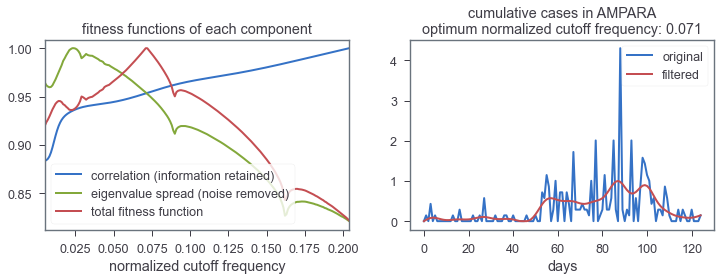

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


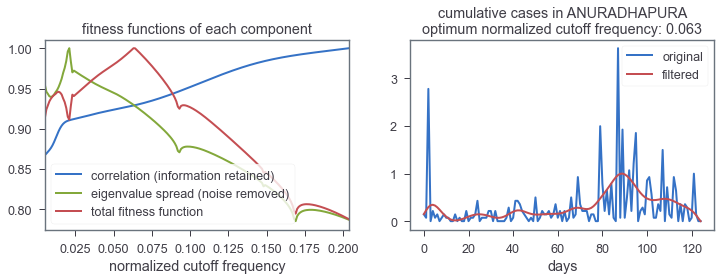

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


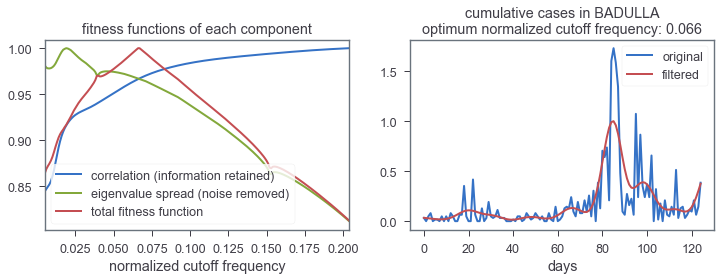

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


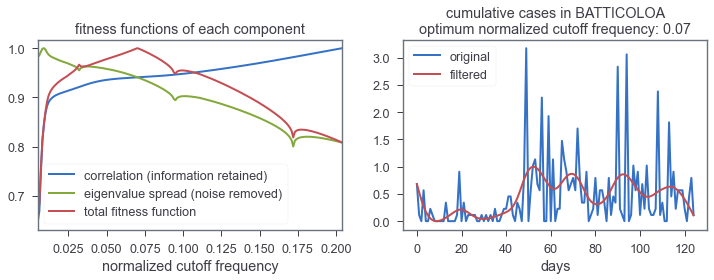

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


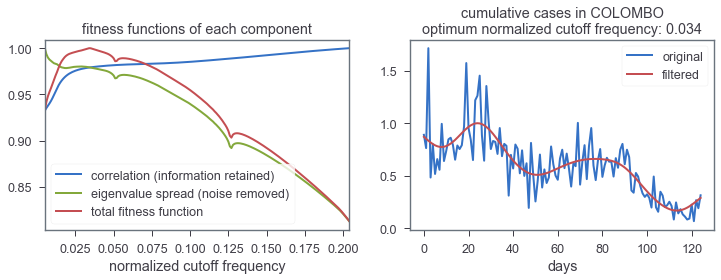

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


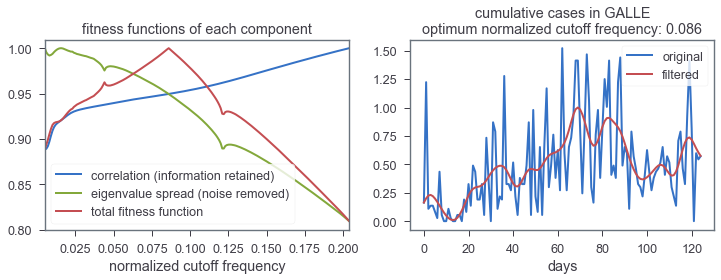

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


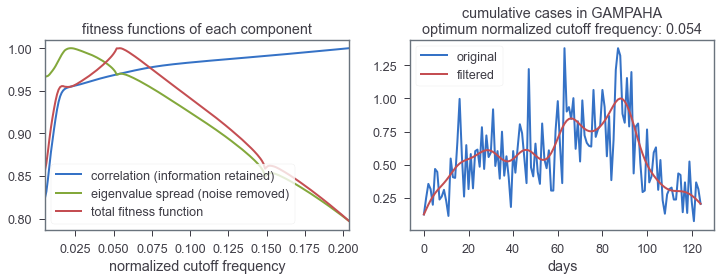

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


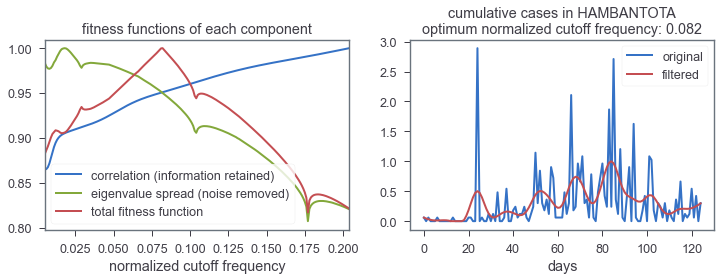

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


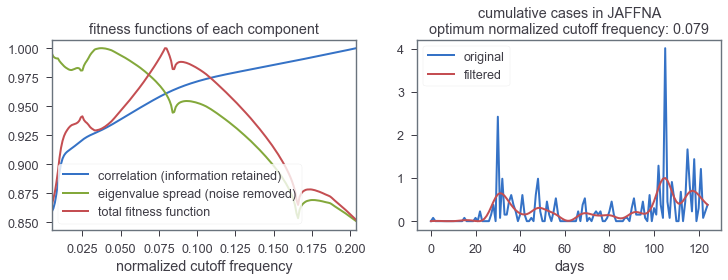

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


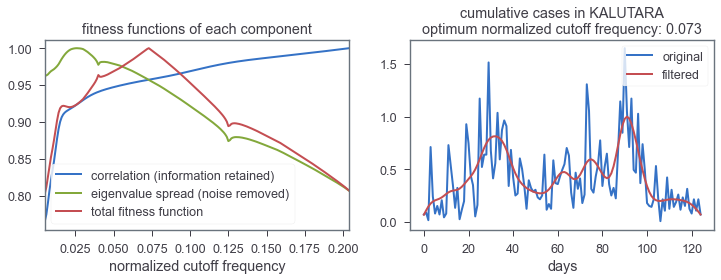

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


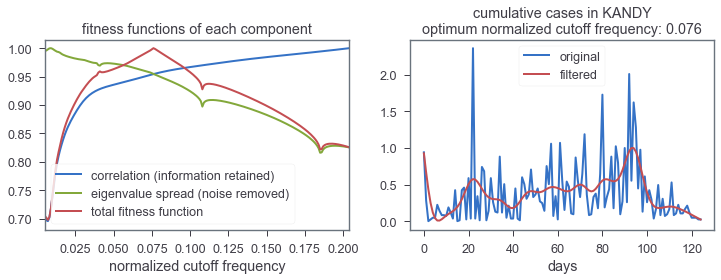

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


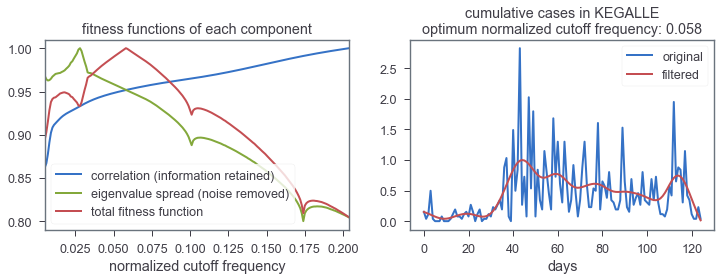

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


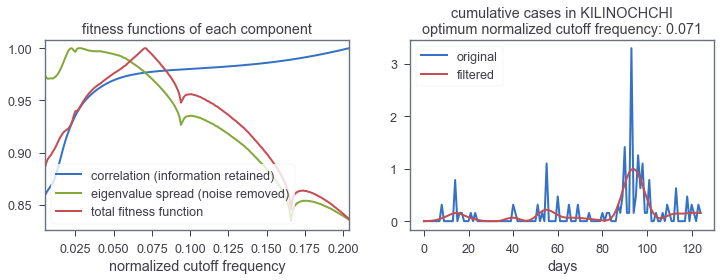

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


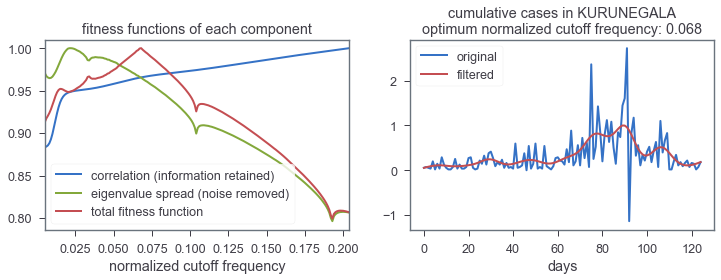

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


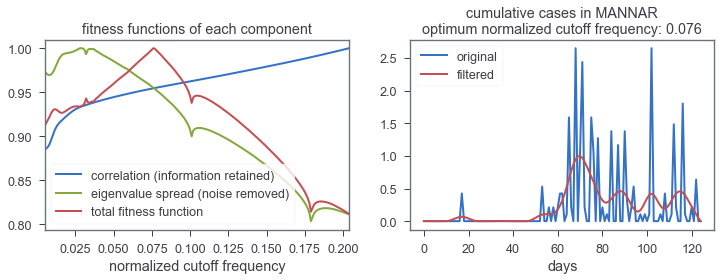

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


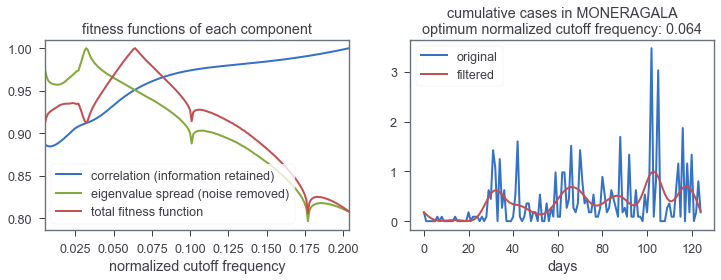

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


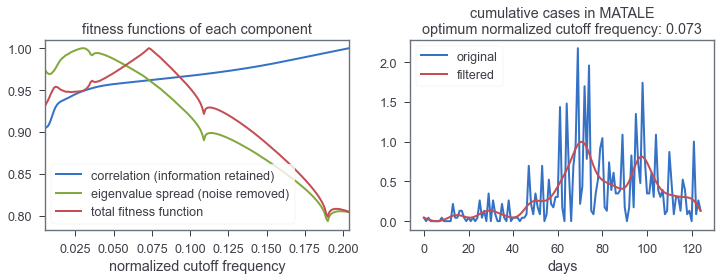

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


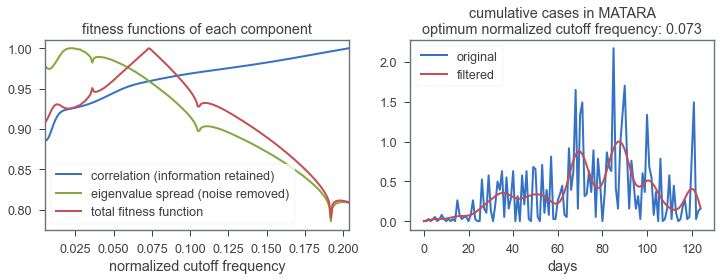

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


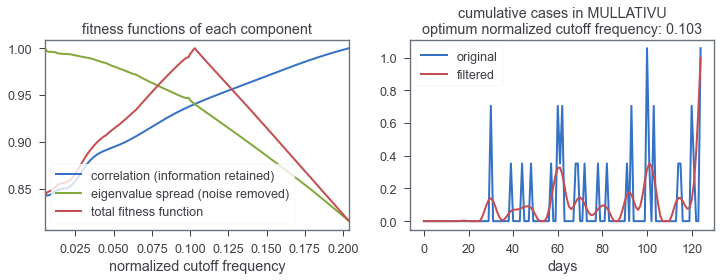

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


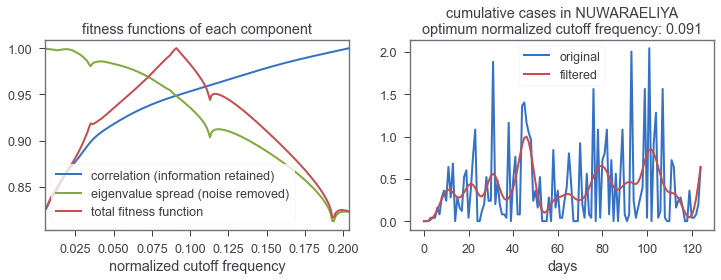

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


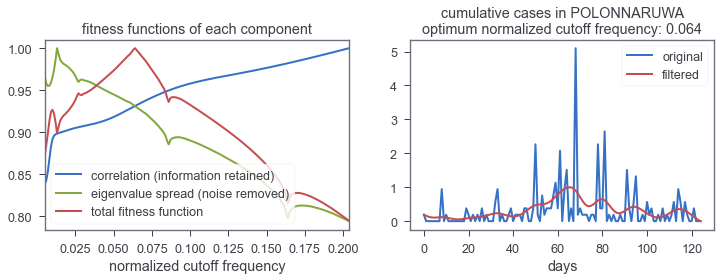

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


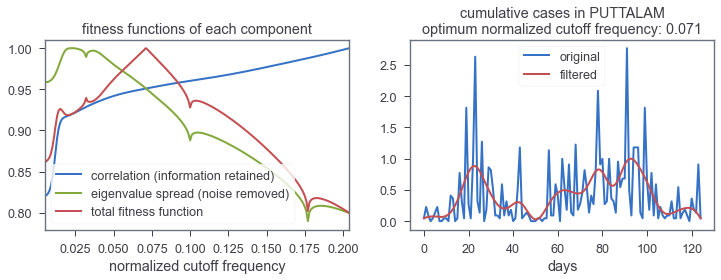

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


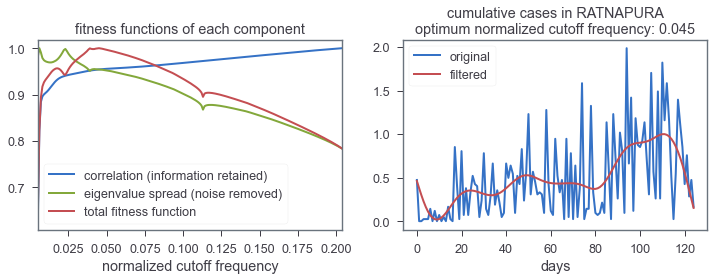

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


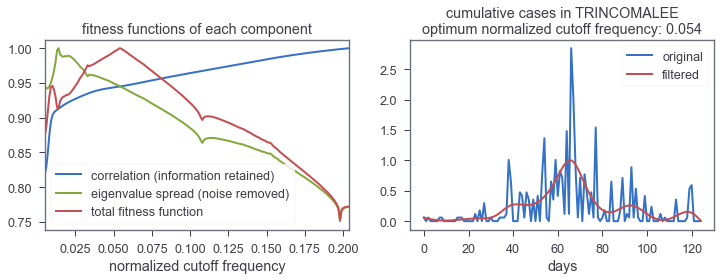

c:\users\umar\appdata\local\programs\python\python38\lib\site-packages\scipy\signal\spectral.py:1961: UserWarning: nperseg = 256 is greater than input length  = 125, using nperseg = 125
  warnings.warn('nperseg = {0:d} is greater than input length '


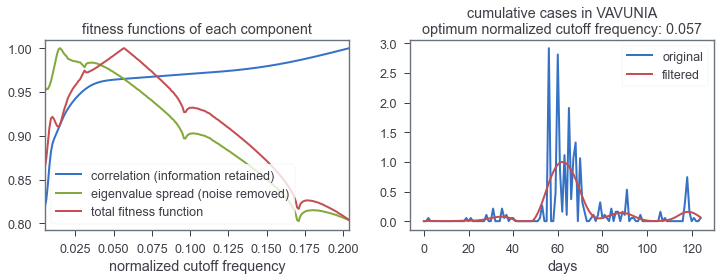

In [33]:
# confirmed_filtered = O_LPF(confirmed_cases, datatype='daily', order=1, R_cons=1, EIG_cons=1, corr = True)
daily_filtered = O_LPF(daily_cases, datatype='daily', order=3, R_weight=1.0, EIG_weight=1, corr = True, region_names=region_names)
# confirmed_filtered = NO_LPF(confirmed_cases)
# confirmed_filtered = O_NDA(confirmed_cases)
# confirmed_filtered = NO_NDA(confirmed_cases)

# print(confirmed_filtered.shape, confirmed_cases.shape)

## Daily cases and per million

In [6]:
#@title Run this cell only if we are going from filtered confirmed -> daily filtered.

if not daily_data:

  # fixing the confirmed cases dataset (negative gradients)
  for k in range(confirmed_filtered.shape[0]):
      for i in range(confirmed_filtered.shape[1]-1):
          if confirmed_filtered[k,i+1]<confirmed_filtered[k,i]:
              confirmed_filtered[k,i+1] = confirmed_filtered[k,i]
  confirmed_per_mio_capita = per_million(confirmed_cases,population)
  confirmed_per_mio_capita_filtered = per_million(confirmed_filtered,population)

  daily_cases = get_daily(confirmed_cases)
  daily_filtered = get_daily(confirmed_filtered)


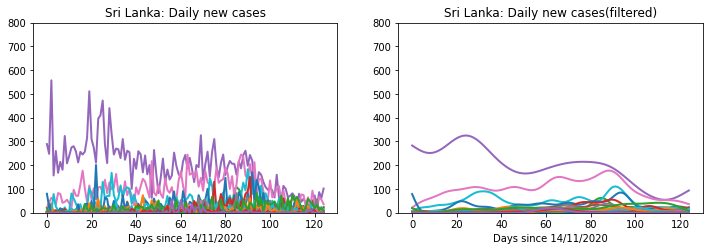

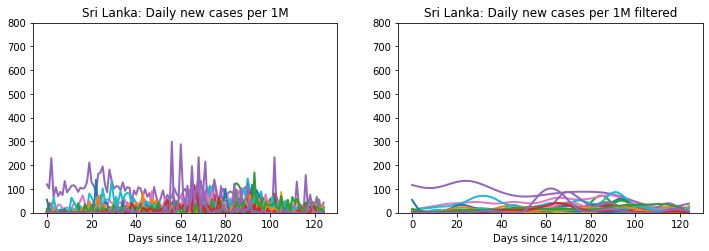

(25, 125) (25, 125)


In [7]:
daily_per_mio_capita = per_million(daily_cases,population)
daily_per_mio_capita_filtered = per_million(daily_filtered,population)


plots = [daily_cases[:,:].T, daily_filtered[:,:].T]
titles = [DATASET+': Daily new cases',DATASET+': Daily new cases(filtered)']
plt.figure(figsize=(12,3.5))
for i in range(len(titles)):
    plt.subplot(1,2,i+1)
    plt.plot(plots[i],linewidth=2)
    plt.title(titles[i]),plt.xlabel('Days since '+START_DATE)
    # plt.ylim([0,5000])
    plt.ylim([0, 800])

plt.show()

plots = [daily_per_mio_capita[:,:].T, daily_per_mio_capita_filtered[:,:].T]
titles = [DATASET+': Daily new cases per 1M',DATASET+': Daily new cases per 1M filtered',]
plt.figure(figsize=(12,3.5))
for i in range(len(titles)):
    plt.subplot(1,2,i+1)
    plt.plot(plots[i],linewidth=2)
    plt.title(titles[i]),plt.xlabel('Days since '+START_DATE)
    plt.ylim([0, 800])
plt.show()
  

if DATASET == 'Texas':
  nums = [50,125]
  plt.figure(figsize=(12,3.5))
  for i in range(len(nums)):
    plt.subplot(1,2,i+1)
    plt.plot(daily_per_mio_capita[nums[i],:].T,linewidth=1.5)
    plt.plot(daily_per_mio_capita_filtered[nums[i],:].T,linewidth=3)
    # plt.ylim([0,800])
  plt.show

print(daily_per_mio_capita.shape, daily_per_mio_capita_filtered.shape)

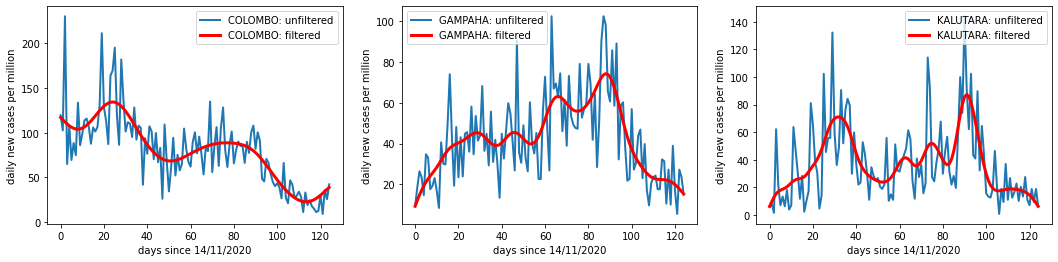

In [8]:
if DATASET=='Sri Lanka':

  select_regions = ['COLOMBO', 'GAMPAHA', 'KALUTARA']
  plt.figure(figsize=(len(select_regions)*6,4))
  for i in range(len(region_names)):
    for j in range(len(select_regions)):
      if region_names[i] == select_regions[j]:
        plt.subplot(1,len(select_regions),j+1)
        plt.plot(daily_per_mio_capita[i,:].T,linewidth=2)
        plt.plot(daily_per_mio_capita_filtered[i,:].T,linewidth=3,color='r')
        plt.xlabel('days since 14/11/2020')
        plt.ylabel('daily new cases per million')
        plt.legend([select_regions[j] + ': unfiltered', select_regions[j] + ': filtered'])



  # plt.figure(figsize=(18,4))
  # for j in range(len(idx)):


In [9]:
len(select_regions)

3

## Creating Alert-Level data

In [ ]:
places = ['COLOMBO','GAMPAHA','KALUTARA']
idx = []

for k in range(len(places)):
  for i in range(len(region_names)):
    if region_names[i]==places[k]:
      idx.append(i)

idx


In [ ]:
def create_alert_level(ts_data,thresholds,logic=1):
    
    inc_thresh = 7
    dec_thresh = 14
    current = 1
    inc_trig = 0
    dec_trig = 0
    al = []
    for i in range(len(ts_data)):
        if ts_data[i] >= thresholds[current]:
            inc_trig += 1
        else:
            inc_trig = 0
        if ts_data[i] < thresholds[current-1]:
            dec_trig += 1
        else:
            dec_trig = 0
        if logic==1:    #high inertia (we dont consider spikes here. we want to see how well it responds. need to quantify it.)
            if inc_trig == inc_thresh:
                current += 1
                inc_trig = 0
            if dec_trig == dec_thresh:
                current -= 1
                dec_trig = 0
        elif logic==2:
            if np.mean(ts_data[max(0,i-inc_thresh):i]) >= thresholds[current]:
                current += 1
            elif np.mean(ts_data[max(0,i-dec_thresh):i]) < thresholds[current-1]:
                current -= 1
        elif logic==3:  #low inertia (we consider spikes here.)
            if ts_data[i]>= thresholds[current]:
                current += 1
            elif ts_data[i] < thresholds[current-1]:
                current -= 1
        al.append(current)
    return al


alert_filt = []
alert_unfilt = []

# Method 1
thresholds = [0,10,20,40,1e1000]
daily_f = daily_per_mio_capita_filtered
daily_uf = daily_per_mio_capita
logic = 3

# Method 2
# thresholds = [0,5,10,100,1e1000]
# daily_f = daily_per_mio_capita_filtered/10
# daily_uf = daily_per_mio_capita/10
# logic = 3

for dist in range(daily_f.shape[0]):
    alert_filt.append(create_alert_level(daily_f[dist,:], thresholds, logic=logic))
alert_filt = np.array(alert_filt)

for dist in range(daily_uf.shape[0]):
    alert_unfilt.append(create_alert_level(daily_uf[dist,:], thresholds, logic=logic))
alert_unfilt = np.array(alert_unfilt)

# plt.figure()
# plt.plot(alert_unfilt.T,linewidth=2)
# plt.title("Alert-level for Unfiltered data"),plt.xlabel('Days since '+START_DATE)
# plt.ylim([0, 5])
# plt.show()

# plt.figure()
# plt.plot(alert_filt.T,linewidth=2)
# plt.title("Alert-level for Filtered data"),plt.xlabel('Days since '+START_DATE)
# plt.ylim([0, 5])
# plt.show()

# count \/ from alert levels
def count_spikes(data):
    count_total = np.zeros([data.shape[0],])
    for d in range(data.shape[0]):
        i = 0
        count=0
        while i<(data.shape[1]-2):
            if data[d,i] - data[d,i+1] == 1 and data[d,i+1] - data[d,i+2] == -1:
                count = count+1
            elif data[d,i] - data[d,i+1] == -1 and data[d,i+1] - data[d,i+2] == 1:
                count = count+1
            i=i+1
        count_total[d]=count
    return count_total

count_unfilt = np.sum(count_spikes(alert_unfilt))
print('count_unfiltered=',count_unfilt)

count_filt = np.sum(count_spikes(alert_filt))
print('count_filtered=',count_filt)

# # removing \/ from alert levels
# def remove_spikes(data):
#     for d in range(data.shape[0]):
#         for i in range(data.shape[1]-2):
#             if data[d,i] - data[d,i+1] == 1 and data[d,i+1] - data[d,i+2] == -1:
#                 data[d,i+1] = data[d,i]
#     return data

# alert_unfilt = remove_spikes(alert_unfilt)
# alert_filt = remove_spikes(alert_filt)

# plt.figure()
# plt.plot(alert_unfilt.T,linewidth=2)
# plt.title("Alert-level for Unfiltered data after filtering spikes"),plt.xlabel('Days since '+START_DATE)
# plt.ylim([0, 5])
# plt.show()

# plt.figure()
# plt.plot(alert_filt.T,linewidth=2)
# plt.title("Alert-level for Filtered data after filtering spikes"),plt.xlabel('Days since '+START_DATE)
# plt.ylim([0, 5])
# plt.show()

alert_f = np.copy(alert_filt)
alert_uf = np.copy(alert_unfilt)


for i in range(len(thresholds)-1):
  alert_f[alert_f==i+1]=thresholds[i]
  alert_uf[alert_uf==i+1]=thresholds[i]



# plt.figure(figsize=(5*5,3*5))
# for i in range(alert_filt.shape[0]):
#   plt.subplot(5,5,i+1)
#   plt.plot(alert_uf[i,:],linewidth=2,color='b')
#   plt.plot(alert_f[i,:],linewidth=2,color='r')
#   plt.plot(daily_uf[i,:],linewidth=1.5,color='y')
#   plt.plot(daily_f[i,:],linewidth=1.5,color='g')
#   plt.xlim([30,120])
# plt.show()
i=13

plt.plot(daily_uf[i,:],'b:')
plt.plot(daily_f[i,:],'r:')
plt.plot(alert_uf[i,:],linewidth=2,color='b')
plt.plot(alert_f[i,:],linewidth=2,color='r')
plt.legend(["original epicurve", "smoothed epicruve","levels computed using original data (scaled)","levels computed using smoothed data (scaled)"])
plt.xlabel('days since 14 Nov 2020')
plt.ylabel('daily cases')
plt.xlim([30,120])
plt.ylim([0, thresholds[-2]+20])
plt.show()

print(i)
print(region_names[i])

In [ ]:
alert_f = np.copy(alert_filt)
alert_uf = np.copy(alert_unfilt)

idx = np.random.randint(0,24,size=(3,))

plt.figure()
for i in range(len(idx)):
  if i==0:
    plt.plot(alert_uf[idx[i],:],'b:')
    plt.plot(alert_f[idx[i],:],linewidth=2,color='b')
  elif i==1:
    plt.plot(alert_uf[idx[i],:],'r:')
    plt.plot(alert_f[idx[i],:],linewidth=2,color='r')
  else:
    plt.plot(alert_uf[idx[i],:],'g:')
    plt.plot(alert_f[idx[i],:],linewidth=2,color='g')

plt.legend([region_names[idx[0]]+': computed using original data', region_names[idx[0]]+': computed using filtered data',
            region_names[idx[1]]+': computed using original data', region_names[idx[1]]+': computed using filtered data',
            region_names[idx[2]]+': computed using original data', region_names[idx[2]]+': computed using filtered data'])

plt.show()
print(idx)


# GSP

## coordinate stuff

In [ ]:
region_codes = features.index
dpmc = pd.Series(daily_cases.mean(axis=1), name="Mean Daily Per Million")
names = pd.Series(region_codes, name="District")
state_data = pd.concat([names, dpmc], 1)
print(state_data)

In [ ]:
state_geo = "maps/LKA_electrol_districts.geojson"


m = folium.Map(location=[8,81], zoom_start=8)
folium.GeoJson(state_geo, name="geojson").add_to(m)

folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=state_data,
    columns=["District", "Mean Daily Per Million"],
    key_on="properties.electoralDistrictCode",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Mean Covid-19 Cases",
).add_to(m)

folium.LayerControl().add_to(m)


Averaging corrdinates of the map to find the longitudes and latitudes of each region

In [ ]:
import json
map_json = json.load(open(state_geo))

dist_coor = {"Code":[],"lon":[],"lat":[]}
for i in range(len(map_json['features'])):
  coor = np.array(map_json['features'][i]['geometry']['coordinates'])
  if len(coor.shape)==3:
    mean_coor = np.mean(coor, 1)[0]
  else:
    mean_coor = []
    for j in range(coor.shape[0]):
      # print(np.shape(coor[j][0]))
      mean_coor.append(np.mean(coor[j][0],0))
    mean_coor = np.mean(mean_coor,0)  
  dist_coor["Code"] += [map_json['features'][i]['properties']['electoralDistrictCode']]
  dist_coor["lon"] += [mean_coor[0]]
  dist_coor["lat"] += [mean_coor[1]]
dist_coor = pd.DataFrame(dist_coor).set_index('Code').sort_index()

print(dist_coor.index)
print(region_codes)

## GSP_old

In [ ]:
def laplacian(A, method=0, plot=False):
    """
    A : adjacency matrix
    method : 0 - combinatorial, 1 - normalized
    """
    A_hat = A + np.identity(A.shape[0]) 
    D_hat = np.zeros_like(A)
    for i in range(D_hat.shape[0]):
        D_hat[i,i] = np.sum(A_hat[i,:])

    if method == 0:
        L = D_hat - A_hat
    elif method == 1:
        D1 = np.sqrt(np.linalg.inv(D_hat))
        A1 = np.matmul(D1,A_hat)
        L = np.identity(A_hat.shape[0]) - np.matmul(A1,D1)
    elif method == 2:
        L = spektral.utils.gcn_filter(A, symmetric=True)
    if plot == True:
        plots, names = np.array([A_hat, D_hat, L]), ['adjacency', 'degree matrix', 'laplacian']
        plt.figure(2,figsize=(16,4))
        for i in range(plots.shape[0]):
            plt.subplot(1,4,i+1),plt.title(names[i]),plt.imshow(plots[i,0:50,0:50]), plt.colorbar()
    return L

In [ ]:
dist_coor = features[['Lat',"Lon"]]
dist_coor

A = convert_lon_lat_to_adjacency_matrix(dist_coor, lat_column="Lat", lon_column="Lon", delta = 1e-5)
plt.imshow(A)
plt.show()

In [ ]:
L = laplacian(A,0, True)

## GSP_new

In [ ]:
def adjacency_mat(X, type_, cutoff, self_loops, is_weighted, plot):  
    nodes = X.shape[0]
    d1 = np.zeros([nodes,nodes])
    d = np.zeros(X.shape[1]) 
    for i in range(nodes):
        for j in range(nodes):
            for k in range(X.shape[1]):
                d[k] = X[i,k]-X[j,k]
            d1[i,j] = np.sqrt(np.sum(np.square(d)))
    dist = d1/np.amax(d1)
    if type_.lower() in ['gaussean']:
        theta = np.mean(dist) 
        A_dense = -1*np.square(dist)/(0.3*np.square(theta))
        A_dense = np.exp(A_dense)
    else: 
        A_dense = 1*dist

    if is_weighted == False: 
        A_dense[A_dense!=0]=1
    if self_loops == False: 
        A_dense = A_dense - np.identity(nodes)
    A = 1*A_dense
    A[dist>cutoff]=0
    if plot == True:
        plots=np.array([dist,A_dense,A])
        titles = ['distance matrix', 'adjacency matrix: dense (without cutoff)', 'adjacency matrix: sparse (with cutoff)']
        plt.figure(figsize=(12,4))
        for i in range(len(plots)):
            plt.subplot(1,3,i+1),plt.imshow(plots[i,0:25,0:25]),plt.title(titles[i])
        plt.show()
    return A

def laplacian(A, type_, plot):
    D = np.zeros_like(A)
    D_hat = np.zeros_like(A)
    A_hat = 1*A
    if A[0,0]==1:
        for i in range(A.shape[0]):          
            A[i,i]=0
    else:
        for i in range(A.shape[0]):
            A_hat[i,i]=1
    for i in range(D.shape[0]):
        D[i,i] = np.sum(A[i,:])
        D_hat[i,i] = np.sum(A_hat[i,:])
    if type_ == 'combinatorial':
        L = D - A 
    elif type_ == 'normalized':
        D = np.sqrt(np.linalg.inv(D))
        L = np.identity(A.shape[0]) - np.matmul(np.matmul(D,A),D)
    if plot == True:
            plots, names = np.array([A_hat, D, L]), ['Adjacency matrix with self loops','Degree','Laplacian']
            plt.figure(figsize=(12,4))
            for i in range(plots.shape[0]):
                plt.subplot(1,3,i+1),plt.title(names[i]),plt.imshow(plots[i,0:25,0:25])  
            plt.show()
    return L

In [ ]:
# GETTING THE COORDINATES for SL
dist_coor = features[['Lat',"Lon"]]
coordinates = np.float64(np.array(dist_coor.iloc[:,:]))

# obtain weight matrices to convert into adjacency matrix
cutoff = 0.2
dist_type = 'gaussean'
laplacian_type = 'normalized'
A = adjacency_mat(coordinates, dist_type, cutoff, self_loops=False, is_weighted =True, plot=True)
L = laplacian(A,laplacian_type, plot=True)

In [ ]:
""" 
eigenvectors of laplacian
"""
[eig_L,v_L] = np.linalg.eig(L)

plt.plot(eig_L)

eig_L.shape, v_L.shape

In [ ]:
# state_var = confirmed_per_mio_capita_filtered
state_var = daily_per_mio_capita_filtered
state_var.shape

""" 
total variation of graph signal (smoothness measure)
"""

total_variation = np.zeros((state_var.shape[1],))

for i in range(state_var.shape[1]):
  temp = np.matmul(L, state_var[:,i]) 
  total_variation[i] = np.matmul(state_var[:,i].T, temp)

""" 
total variation of eigenvectors (signal energy)
"""
total_variation_eig = np.zeros((v_L.shape[0],))

for i in range(v_L.shape[0]):
  temp = np.matmul(L, v_L[:,i]) 
  total_variation_eig[i] = np.matmul(v_L[:,i].T, temp)


""" 
graph fourier transform
"""
state_var_GFT = np.zeros_like(state_var)

for i in range(state_var_GFT.shape[1]):
  state_var_GFT[:,i] = np.matmul(v_L.T, state_var[:,i])

""" 
lowpass filters
"""
filter_size = 10
filter_start = 0

H_L = np.zeros((filter_size))


In [ ]:
plt.plot(total_variation)

# TRAINING MODEL

In [ ]:
# TRAINING PARAMETERS
batch_size = 16
epochs = 100
lr = 0.002
seq_size = 14
predict_steps = 6
n_dem = 16
s_per_example = 30
n_features = 4

## Dense Models

In [ ]:
reduce_regions2batch = True
model_type = "DENSE"
def get_model_ANN(seq_size, predict_steps, n_features=n_features, n_regions=n_regions):
    
    inp_seq = tf.keras.layers.Input(seq_size, name="input_sequence")
    inp_fea = tf.keras.layers.Input(n_features, name="input_features")
    
    x = inp_seq
    xf = inp_fea
    n = n_features
    while (n>0):
        xf = tf.keras.layers.Dense(n,activation='relu')(xf) 
        n = n//2
    
    x = tf.keras.layers.Dense(10, activation='relu')(x)
    x = tf.keras.layers.Dense(predict_steps,activation='relu')(x)
    
    if n_features > 0:
        x = x*xf
    model = tf.keras.models.Model([inp_seq,inp_fea], x)
    return model

model_ANN = get_model_ANN(seq_size, predict_steps)
model_ANN.summary()
tf.keras.utils.plot_model(model_ANN, show_shapes=True, rankdir='LR')

In [ ]:
reduce_regions2batch = False
model_type = "DENSE"
def get_model_ANN(input_seq_size, output_seq_size, n_features=n_features, n_regions=n_regions):
    
    inp_seq = tf.keras.layers.Input((input_seq_size,n_regions), name="input_sequence")
    inp_fea = tf.keras.layers.Input((n_features,n_regions), name="input_features")
    
    x = tf.keras.layers.Reshape((input_seq_size*n_regions,))(inp_seq)
    x = tf.keras.layers.Dense(output_seq_size*n_regions, activation='sigmoid')(x)
    x = tf.keras.layers.Reshape((output_seq_size,n_regions))(x)

    model = tf.keras.models.Model([inp_seq, inp_fea], x)
    return model
model_ANN = get_model_ANN(seq_size, predict_steps, n_regions=n_regions)
model_ANN.summary()
tf.keras.utils.plot_model(model_ANN, show_shapes=True, rankdir='LR')

## LSTM Models

In [ ]:
reduce_regions2batch = True
model_type = "LSTM"
def get_model_LSTM(input_seq_size, output_seq_size, n_features=n_features, n_regions=n_regions):
    inp_seq = tf.keras.layers.Input((input_seq_size,1), name="input_seq")
    inp_fea = tf.keras.layers.Input(n_features, name="input_fea")
    
    out = tf.keras.layers.LSTM(output_seq_size, activation='sigmoid')(inp_seq)
    
    model = tf.keras.models.Model([inp_seq,inp_fea], out)
    return model


model_LSTM = get_model_LSTM(seq_size, predict_steps)
model_LSTM.summary()
tf.keras.utils.plot_model(model_LSTM, show_shapes=True, rankdir='LR')

In [ ]:
reduce_regions2batch = False
model_type = "LSTM"
def get_model_LSTM(input_seq_size, output_seq_size, n_regions):
    
    inp_seq = tf.keras.layers.Input((input_seq_size,n_regions), name="input_seq")
    x = tf.keras.layers.LSTM(output_seq_size*n_regions, activation='sigmoid')(inp_seq)
    x = tf.keras.layers.Reshape((output_seq_size, n_regions))(x)
    
    model = tf.keras.models.Model(inp_seq, x)
    
    return model

model_LSTM = get_model_LSTM(seq_size, predict_steps, n_regions)
model_LSTM.summary()
tf.keras.utils.plot_model(model_LSTM, show_shapes=True, rankdir='LR')

In [ ]:
reduce_regions2batch = False
model_type = "LSTM_MULTI"
def get_model_LSTM(input_seq_size, output_seq_size, n_regions):
    
    inp_seq = tf.keras.layers.Input((input_seq_size,n_regions), name="input_seq")
    
    lstm_input = inp_seq
    for i in range(output_seq_size):
      xx = tf.keras.layers.LSTM(n_regions, activation='relu')(lstm_input)
      if i==0:
        out = xx
      else:
        out = tf.keras.layers.concatenate([out,xx])

      xx = tf.reshape(xx,(-1,1,n_regions))
      lstm_input = tf.keras.layers.concatenate([lstm_input[:,1:,:], xx], axis=1)
    
    out = tf.reshape(out,(-1,output_seq_size,n_regions))
    model = tf.keras.models.Model(inp_seq, out)
    return model

model_LSTM_multi = get_model_LSTM(seq_size, predict_steps, n_regions)
model_LSTM_multi.summary()
tf.keras.utils.plot_model(model_LSTM_multi, show_shapes=True, rankdir='TB')

## Select Training model

In [ ]:
def reset():
  if model_type == "DENSE":
    model = get_model_ANN(seq_size, predict_steps, n_regions)
  elif model_type == "LSTM":
    model =  get_model_LSTM(seq_size, predict_steps, n_regions)
  elif model_type == "LSTM_MULTI":
    model =  get_model_LSTM(seq_size, predict_steps, n_regions)
  loss_f = tf.keras.losses.MeanSquaredError()
  opt = Adam(lr=lr)
  return model, loss_f, opt

def eval_metric(y_true, y_pred):  
  return np.mean((y_true-y_pred)**2)**0.5

model, loss_f, opt = reset()
model.summary()

## Select training data

Run the required cell

### FILTERED DATA

In [ ]:
def get_data_daily():
    x_data = np.copy(daily_per_mio_capita_filtered)
    y_data = np.copy(daily_per_mio_capita_filtered)
    # y_data = np.copy(alert_unfilt)
    return x_data, y_data


def get_data_confirmed():
    x_data = np.copy(confirmed_per_mio_capita_filtered)
    y_data = np.copy(confirmed_per_mio_capita_filtered)
    #y_data = np.copy(alert_unfilt)
    return x_data, y_data

TRAINING_DATA_TYPE = "Filtered"

### UNFILTERED DATA

In [ ]:
def get_data_daily():
    x_data = np.copy(daily_per_mio_capita)
    y_data = np.copy(daily_per_mio_capita)
    #y_data = np.copy(alert_unfilt)
    return x_data, y_data

def get_data_confirmed():
    x_data = np.copy(confirmed_per_mio_capita)
    y_data = np.copy(confirmed_per_mio_capita)
    #y_data = np.copy(alert_unfilt)
    return x_data, y_data

TRAINING_DATA_TYPE = "Unfiltered"

## Spliting and reshaping data

### Normalizing functions

In [ ]:
# ==================================== TODO: find a good normalization technique
def normalize_for_nn(data, given_scalers=None):
  print(f"NORMALIZING; Data: {data.shape}")
  data = data.astype('float32')
  scalers = []
  for i in range(data.shape[0]):
    if given_scalers is not None:
      scale = given_scalers[i]
    else:
      scale = float(np.max(data[:,:]))
    scalers.append(scale)
    data[i,:] /= scale
  return data, scalers

def undo_normalization(normalized_data, scalers):
  print(f"UNNORMALIZING; Norm Data: {normalized_data.shape}")
  for i in range(len(scalers)):
    normalized_data[:,:,i] *= scalers[i]
  return normalized_data


### Split dataset on region dimension.

In [ ]:
if daily_data == True:
  x_data, y_data = get_data_daily()
else:
  x_data, y_data = get_data_confirmed()


x_data, x_data_scalers=normalize_for_nn(x_data)
y_data, x_data_scalers=normalize_for_nn(y_data,x_data_scalers)

plt.figure()
plt.subplot(121)
plt.plot(x_data.T), plt.title("X data")
plt.subplot(122)
plt.plot(y_data.T), plt.title("Y data")
plt.show()

plt.figure()
plt.subplot(121)
plt.hist(x_data.reshape(-1)), plt.title("X data")
plt.subplot(122)
plt.hist(y_data.reshape(-1)), plt.title("Y data")
plt.show()

#shuffle regions so that we don't get the same k fold everytime 
index = np.arange(x_data.shape[0])
np.random.shuffle(index)
x_data = x_data[index]
y_data = y_data[index]
X_train, Y_train, X_val, Y_val, X_test, Y_test = split_on_region_dimension(x_data, y_data, seq_size, predict_steps, s_per_example, 
                                                         k_fold=5, test_fold=1, reduce_last_dim=reduce_regions2batch)

print("Train", X_train.shape, Y_train.shape)
print("Val", X_val.shape, Y_val.shape)
print("Test", X_test.shape, Y_test.shape)


### Split dataset on time dimension.

 First, we split the dataset into a subset called the training set, and another subset called the test set. If any parameters need to be tuned, we split the training set into a training subset and a validation set. The model is trained on the training subset and the parameters that minimize error on the validation set are chosen. Finally, the model is trained on the full training set using the chosen parameters, and the error on the test set is recorded.

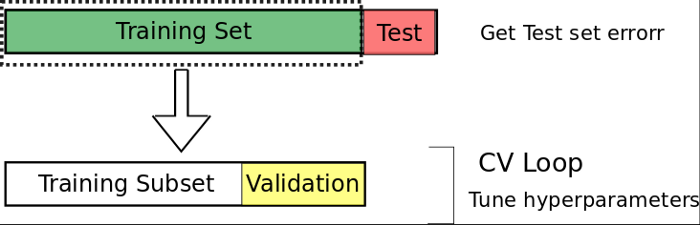

When dealing with time series data, traditional cross-validation (like k-fold) should not be used for two reasons:Temporal Dependencies,Arbitrary Choice of Test Set

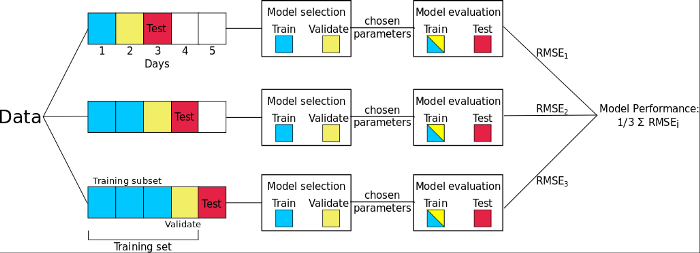

In [ ]:
if daily_data == True:
  x_data, y_data = get_data_daily()
else:
  x_data, y_data = get_data_confirmed()


x_data, x_data_scalers=normalize_for_nn(x_data)
y_data, x_data_scalers=normalize_for_nn(y_data,x_data_scalers)

plt.figure()
plt.subplot(121)
plt.plot(x_data.T), plt.title("X data")
plt.subplot(122)
plt.plot(y_data.T), plt.title("Y data")
plt.show()

plt.figure()
plt.subplot(121)
plt.hist(x_data.reshape(-1)), plt.title("X data")
plt.subplot(122)
plt.hist(y_data.reshape(-1)), plt.title("Y data")
plt.show()

# shuffle regions so that we don't get the same k fold everytime (Should we do this???)
# index = np.arange(x_data.shape[0])
# np.random.shuffle(index)
# x_data = x_data[index]
# y_data = y_data[index]
X_train, X_train_feat, Y_train, X_val, X_val_feat, Y_val, X_test, X_test_feat, Y_test = split_on_time_dimension(x_data, y_data, features, seq_size, predict_steps,  
                                                         k_fold=3, test_fold=2, reduce_last_dim=reduce_regions2batch)

print("Train", X_train.shape, Y_train.shape, X_train_feat.shape)
print("Val", X_val.shape, Y_val.shape, X_val_feat.shape)
print("Test", X_test.shape, Y_test.shape,X_test_feat.shape)


In [ ]:
X_train, X_train_feat, Y_train, X_val, X_val_feat, Y_val, X_test, X_test_feat, Y_test = split_on_time_dimension(x_data, y_data, features, seq_size, predict_steps, s_per_example, 
                                                         k_fold=3, test_fold=2, reduce_last_dim=False)
plt.imshow(X_train_feat[0,:,:])
print(X_train_feat.shape)

In [ ]:
features

## Training phase

In [ ]:
k_fold = 5

In [ ]:
folder = time.strftime('%Y.%m.%d-%H.%M.%S', time.localtime())+"_"+DATASET
os.makedirs('./logs/' + folder)
tensorboard = TensorBoard(log_dir='./logs/' + folder, write_graph=True, histogram_freq=1, write_images=True)
tensorboard.set_model(model)

train_metric = []
val_metric = []
test_metric = []


if daily_data == True:
  x_data, y_data = get_data_daily()
else:
  x_data, y_data = get_data_confirmed()

x_data, x_data_scalers=normalize_for_nn(x_data)
y_data, x_data_scalers=normalize_for_nn(y_data,x_data_scalers)

#shuffle regions so that we don't get the same regions order everytime  when training
index = np.arange(x_data.shape[0])
np.random.shuffle(index)
x_data = x_data[index]
y_data = y_data[index]
best_test_value = 1e10
for test_fold in range(k_fold-1,k_fold):
    print(f"************* k fold: {test_fold}/{k_fold}")
    model_name = DATASET + "_" + model_type + "_" + TRAINING_DATA_TYPE + "_fold_" + str(test_fold)
    # model, loss_f, opt = reset()

    # X_train, Y_train, X_val, Y_val, X_test, Y_test = split_on_time_dimension(x_data, y_data, seq_size, predict_steps, s_per_example, 
    #                                                      k_fold=k_fold, test_fold=test_fold, reduce_last_dim=reduce_regions2batch)

    # for epoch in range(epochs):
    #     losses = []
    #     for i in range(0, len(X_train), batch_size):
    #         if i + batch_size > len(X_train):
    #             continue
    #         x = X_train[i:i+batch_size]
    #         y = Y_train[i:i+batch_size]
    #         # compute loss for that batch
    #         with tf.GradientTape() as tape:
    #             y_pred = model(x, training=True)
    #             loss = tf.reduce_mean(loss_f(y, y_pred))
    #         # compute d(loss)/d(weight)
    #         grad = tape.gradient(loss, model.trainable_variables)
    #         # gradients applied to optimizer
    #         opt.apply_gradients(zip(grad, model.trainable_variables))
            
    #         losses.append(loss)

    #         # val loss
    #         val_loss = loss_f(Y_val, model(X_val, training=False))

    #         print(f"\r Epoch {epoch}: mean loss = {np.mean(losses):.5f} mean val loss = {np.mean(val_loss):.5f}", end='')
            
    #     # add metric value of the prediction (from training data)
    #     pred_train_y = model(X_train, training=False)
    #     train_metric.append(eval_metric(Y_train,pred_train_y))

    #     pred_val_y = model(X_val, training=False)
    #     val_metric.append(eval_metric(Y_val,pred_val_y))

    #     # add metric value of the prediction (from testing data)
    #     pred_test_y = model(X_test, training=False)
    #     test_metric.append(eval_metric(Y_test,pred_test_y))

    #     tensorboard.on_epoch_end(epoch, {"loss": np.mean(losses)})

    #     #   plt.subplot(122)
    #     #   if len(model.output.shape) == 2:
    #     #       Y_pred = np.zeros_like(Y_test)
    #     #       Y_pred[:,:,i] = model(X_test[:,:,i])
    #     #   else:
    #     #       Y_pred = model(X_test).numpy()
    #     #   plot_prediction(X_test, Y_test, Y_pred, region_names)
    #     #   plt.setp(plt.gca().get_legend().get_texts(), fontsize='5') # for legend text
    #     #   plt.setp(plt.gca().get_legend().get_title(), fontsize='5') # for legend title
    #     #   plt.show()
    # plt.figure(figsize=(10,3))
    # plt.subplot(121)
    # plt.ion()
    # plt.plot(train_metric, label='Train')
    # plt.plot(val_metric, label='Validation')
    # plt.plot(test_metric, label='Test')
    # plt.xlabel("Epoch")
    # plt.ylabel("Metric")
    # plt.legend()
    # plt.ioff()
    # plt.show()
    # train_metric = []
    # val_metric = []
    # test_metric = []

    # 
    # model.save(model_name+".h5")

    print("Adjusting hyperparameters ... ")

    print("Training using training+validation data.")
    model, loss_f, opt = reset()
    
    X_train, Y_train,X_train_feat = np.concatenate([X_train, X_val],0), np.concatenate([Y_train, Y_val],0), np.concatenate([X_train_feat, X_val_feat],0)
    for epoch in range(epochs):
        losses = []
        for i in range(0, len(X_train), batch_size):
            if i + batch_size > len(X_train):
                continue
            x = X_train[i:i+batch_size]
            y = Y_train[i:i+batch_size]
            
            with tf.GradientTape() as tape:
                y_pred = model(x, training=True)
                loss = tf.reduce_mean(loss_f(y, y_pred))
            
            grad = tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(grad, model.trainable_variables))
            losses.append(loss)

            print(f"\r Epoch {epoch}: mean loss = {np.mean(losses):.5f}", end='')
            
        # add metric value of the prediction (from training data)
        pred_train_y = model(X_train, training=False)
        train_metric.append(eval_metric(Y_train,pred_train_y))
        # add metric value of the prediction (from testing data)
        pred_test_y = model(X_test, training=False)
        test_metric.append(eval_metric(Y_test,pred_test_y))
        if test_metric[-1] < best_test_value:
          best_test_value = test_metric[-1]
          model.save("temp.h5")
          print(f"Best test metric {best_test_value}. Saving model...")

    plt.figure(figsize=(10,3))
    plt.subplot(121)
    plt.ion()
    plt.plot(train_metric, label='Train')
    plt.plot(test_metric, label='Test')
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.legend()
    plt.ioff()
    plt.show()
    train_metric = []
    test_metric = []
model =  tf.keras.models.load_model("temp.h5")
fmodel_name = DATASET + "_" + model_type + "_" + TRAINING_DATA_TYPE
model.save("models/"+fmodel_name+".h5")

## Loading a model from drive

In [ ]:
print(os.getcwd())
model_name = input("Give path to the model: ")
model = tf.keras.models.load_model(model_name)

model_name_ = model_name.split("_")
DATASET = model_name_[0]
model_type = model_name_[1]
TRAINING_DATA_TYPE = model_name_[2]

# Evaluating models

Our strategy to get the results

---



1.   Train filtered data - Test filtered data
    1. Compare predicted filtered with raw filtered data
    2. Compare predicted filtered with raw unfiltered data
2.   Train unfiltered data - Test unfiltered data
    1. Compare predicted unfiltered with **raw filtered data*** (we are saying that filtered data is smooth/generally good. the idea of predicting unfiltered data is that it is much closer to ground truth of unfiltered data. Therefore no point of comparing with filtered data.)
    2. Compare predicted unfiltered with raw unfiltered data

*we use unfiltered data for eveything except for evaluation 


## Helper functions for evaluation

In [ ]:
def eval_model(model,x_data_raw,y_data_raw,dis=18,predict_data_label="Unfiltered"):

    x_data, x_data_scalers=normalize_for_nn(x_data_raw)
    y_data, x_data_scalers=normalize_for_nn(y_data_raw, x_data_scalers)
    X_train, Y_train, X_val, Y_val, X_test, Y_test = split_on_time_dimension(x_data, y_data, seq_size, predict_steps, s_per_example, 
                                                         k_fold=k_fold, test_fold=k_fold-1, reduce_last_dim=False)
    if len(model.output.shape)==2:
        Y_pred = np.zeros_like(Y_test)
        for i in range(len(region_names)):
            Y_pred[:,:,i] = model(X_test[:,:,i])
    else:
        Y_pred = model(X_test).numpy()

    
    Y_test = undo_normalization(Y_test, x_data_scalers)
    Y_pred = undo_normalization(Y_pred, x_data_scalers)

    rmse = np.mean((Y_test- Y_pred)**2)**0.5
    mae = np.mean((np.abs(Y_test- Y_pred)))
    print(f"RMSE={rmse:.2f} MAE={mae:.2f}")


    # CREATING TRAIN-TEST SETS FOR CASES
    X_test, Y_test = split_into_pieces_inorder(x_data,y_data, seq_size, predict_steps, s_per_example, seq_size+predict_steps, reduce_last_dim=False)
    
    if len(model.output.shape)==2:
        Y_pred = np.zeros_like(Y_test)
        for i in range(len(region_names)):
            Y_pred[:,:,i] = model(X_test[:,:,i])
    else:
        Y_pred = model(X_test).numpy()

    # NOTE:
    # max value may change with time. then we have to retrain the model!!!!!!
    # we can have a predefined max value. 1 for major cities and 1 for smaller districts
    X_test = undo_normalization(X_test, x_data_scalers)
    Y_test = undo_normalization(Y_test, x_data_scalers)
    Y_pred = undo_normalization(Y_pred, x_data_scalers)

    print(x_data_scalers)
    tmp = []
    tmpgt = []
    
    for i in range(len(X_test)):
      for j in range(seq_size):
        tmp.append(X_test[i,j,dis])
        tmpgt.append(X_test[i,j,dis])
      for j in range(predict_steps):
        tmp.append(Y_pred[i,j,dis])
        tmpgt.append(Y_test[i,j,dis])
      
    plt.figure(figsize=(10,10))
    plt.plot(tmpgt)
    plt.plot(tmp)
    plt.plot(y_data_raw[dis,:],'--')
    plt.plot(x_data_raw[dis,:],'--')
    plt.legend(['ground truth', 'forecast','all GT data','all Input data'])
    plt.title(f"Sample district {region_names[dis]}"),plt.xlabel("Days"),plt.ylabel("Cases")
    plt.show()

    region_mask = (np.mean(x_data_raw,1) > 80).astype('int32')

    plt.figure(figsize=(20,10))
    plot_prediction2(X_test, Y_test, Y_pred, region_names, region_mask)
    plt.savefig(f"images/{model_type}_{TRAINING_DATA_TYPE}_{predict_data_label}.eps")
    plt.savefig(f"images/{model_type}_{TRAINING_DATA_TYPE}_{predict_data_label}.jpg")
    plt.show()

   

## Evaluate on unfiltered data

In [ ]:
print(f"=================================== Trained on {TRAINING_DATA_TYPE} data. Evaluating on Unfiltered data")

if daily_data == True:
  x_data, y_data = get_data_daily()
  y_data = np.copy(daily_per_mio_capita)
else:
  x_data, y_data = get_data_confirmed()
  y_data = np.copy(confirmed_per_mio_capita)
# y_data = np.copy(alert_unfilt) 

plt.plot(x_data.T), plt.title("Input original data"), plt.xlabel("Days"), plt.ylabel("Cases"),plt.show()
plt.plot(y_data.T), plt.title("Expecting prediction (GT)"), plt.xlabel("Days"), plt.ylabel("Cases"),plt.show()

eval_model(model,x_data,y_data,dis=0,predict_data_label="Unfiltered")

## Evaluate on Filtered data

In [ ]:

print(f"================================= Trained on {TRAINING_DATA_TYPE} data. Evaluating on Filtered data")
# x_data = np.copy(daily_per_mio_capita_filtered) 
# y_data = np.copy(daily_per_mio_capita_filtered) 

if daily_data == True:
  x_data, y_data = get_data_daily()
  y_data = np.copy(daily_per_mio_capita_filtered) 
else:
  x_data, y_data = get_data_confirmed()
  y_data = np.copy(confirmed_per_mio_capita_filtered)

# y_data = np.copy(alert_unfilt) 

eval_model(model,x_data,y_data,dis=0,predict_data_label="Filtered")

In [ ]:
x=14
start_seqs = [np.random.random((1,x))*0,
              np.ones((1,x))*0,
              np.ones((1,x))*0.5,
              np.ones((1,x))*1,
              np.arange(x).reshape((1,x))/30,
              np.sin(np.arange(x)/x*np.pi/2).reshape((1,x))
]

predictions = []
for start_seq in start_seqs:
  input_seq = np.copy(start_seq)
  predict_seq = [start_seq[0]]
  for _ in range(50):
    output = model(input_seq, training=False)
    predict_seq.append(output[0])
    input_seq = input_seq[:,output.shape[1]:]
    input_seq = np.append(input_seq, output).reshape((1,-1))
  
  predictions.append(np.concatenate(predict_seq))
plt.plot(np.array(predictions).T)
plt.show()


In [ ]:
x = 21
start_seqs = [np.random.random((1,x,1))*0,
              np.ones((1,x,1))*0,
              np.ones((1,x,1))*0.5,
              np.ones((1,x,1))*1,
              np.arange(x).reshape((1,x,1))/30,
              np.sin(np.arange(x)/x*np.pi/2).reshape((1,x,1))
]

predictions = []
for start_seq in start_seqs:
  input_seq = np.copy(start_seq)
  predict_seq = [start_seq[0,:,0]]
  for _ in range(10):
    output = model(input_seq, training=False)
    predict_seq.append(output[0])
    input_seq = input_seq[:,output.shape[1]:,:]
    input_seq = np.append(input_seq, output).reshape((1,-1,1))
  predictions.append(np.concatenate(predict_seq))
plt.plot(np.array(predictions).T)
plt.show()
